In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Activation
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from tensorflow.keras import regularizers, models, layers
from sklearn.preprocessing import StandardScaler

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
tf.keras.backend.clear_session()

In [3]:
import wandb
import optuna

from wandb.integration.keras import WandbMetricsLogger

wandb.require("core")
wandb.login()

wandb: WARNING `wandb.require('core')` is a no-op as it is now the default behavior.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin


True

In [4]:
# Carga de los datos

ds = pd.read_csv("/global_house_purchase_dataset.csv")
ds.head()

,property_id,country,city,property_type,furnishing_status,property_size_sqft,price,constructed_year,previous_owners,rooms,...,customer_salary,loan_amount,loan_tenure_years,monthly_expenses,down_payment,emi_to_income_ratio,satisfaction_score,neighbourhood_rating,connectivity_score,decision
0,1,France,Marseille,Farmhouse,Semi-Furnished,991,412935,1989,6,6,...,10745,193949,15,6545,218986,0.16,1,5,6,0
1,2,South Africa,Cape Town,Apartment,Semi-Furnished,1244,224538,1990,4,8,...,16970,181465,20,8605,43073,0.08,9,1,2,0
2,3,South Africa,Johannesburg,Farmhouse,Semi-Furnished,4152,745104,2019,5,2,...,21914,307953,30,2510,437151,0.09,6,8,1,0
3,4,Germany,Frankfurt,Farmhouse,Semi-Furnished,3714,1110959,2008,1,3,...,17980,674720,15,8805,436239,0.33,2,6,6,0
4,5,South Africa,Johannesburg,Townhouse,Fully-Furnished,531,99041,2007,6,3,...,17676,65833,25,8965,33208,0.03,3,3,4,0


In [5]:
print("NaN values: \n \n ", ds.isna().sum(),
      "\n \n Types: \n \n", ds.dtypes)

NaN values: 
 
  property_id                0
country                    0
city                       0
property_type              0
furnishing_status          0
property_size_sqft         0
price                      0
constructed_year           0
previous_owners            0
rooms                      0
bathrooms                  0
garage                     0
garden                     0
crime_cases_reported       0
legal_cases_on_property    0
customer_salary            0
loan_amount                0
loan_tenure_years          0
monthly_expenses           0
down_payment               0
emi_to_income_ratio        0
satisfaction_score         0
neighbourhood_rating       0
connectivity_score         0
decision                   0
dtype: int64 
 
 Types: 
 
 property_id                  int64
country                     object
city                        object
property_type               object
furnishing_status           object
property_size_sqft           int64
price               

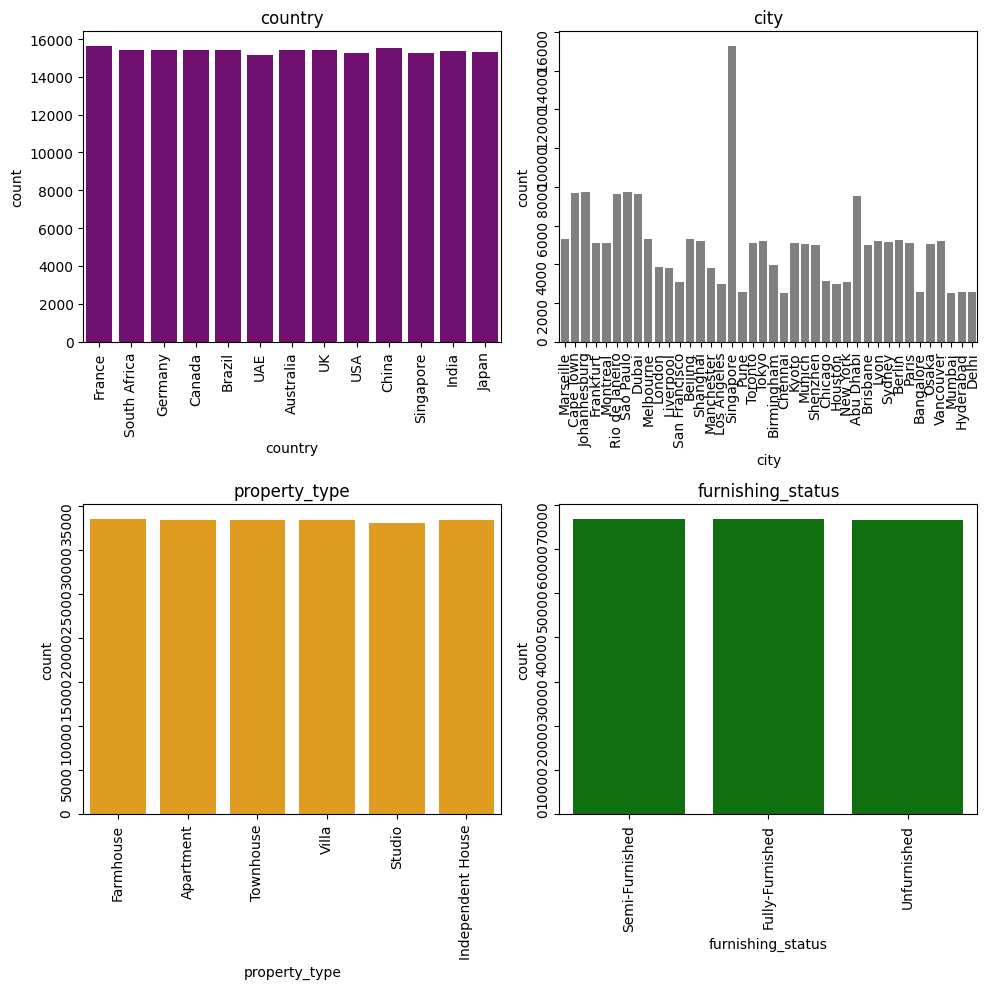

In [6]:
fig, axes = plt.subplots(2, 2, figsize = (10,10))
axes = axes.flatten()

sns.countplot(ds, x = "country", color = "purple", ax = axes[0])
axes[0].tick_params(axis="x", rotation=90)
axes[0].set_title("country")

sns.countplot(ds, x = "city", color = "grey", ax = axes[1])
axes[1].tick_params(rotation = 90)
axes[1].set_title("city")

sns.countplot(ds, x = "property_type", color = "orange", ax = axes[2])
axes[2].tick_params(rotation = 90)
axes[2].set_title("property_type")

sns.countplot(ds, x = "furnishing_status", color = "green", ax = axes[3])
axes[3].tick_params(rotation = 90)
axes[3].set_title("furnishing_status")

plt.tight_layout()
plt.show() 

In [7]:
# One hot encoding

ds = pd.get_dummies(ds, columns = ["country", "city", "property_type", "furnishing_status"],
                            drop_first = False)
ds.drop("property_id", axis = 1, inplace = True)
ds = ds.astype("float32")

ds.head()

,property_size_sqft,price,constructed_year,previous_owners,rooms,bathrooms,garage,garden,crime_cases_reported,legal_cases_on_property,...,city_Vancouver,property_type_Apartment,property_type_Farmhouse,property_type_Independent House,property_type_Studio,property_type_Townhouse,property_type_Villa,furnishing_status_Fully-Furnished,furnishing_status_Semi-Furnished,furnishing_status_Unfurnished
0,991.0,412935.0,1989.0,6.0,6.0,2.0,1.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1244.0,224538.0,1990.0,4.0,8.0,8.0,1.0,1.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,4152.0,745104.0,2019.0,5.0,2.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,3714.0,1110959.0,2008.0,1.0,3.0,3.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,531.0,99041.0,2007.0,6.0,3.0,3.0,1.0,1.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


In [8]:
print("\n \n Types: \n \n", ds.dtypes)


 
 Types: 
 
 property_size_sqft                   float32
price                                float32
constructed_year                     float32
previous_owners                      float32
rooms                                float32
                                      ...   
property_type_Townhouse              float32
property_type_Villa                  float32
furnishing_status_Fully-Furnished    float32
furnishing_status_Semi-Furnished     float32
furnishing_status_Unfurnished        float32
Length: 82, dtype: object


In [9]:
x = ds.drop("decision", axis=1)
y = ds["decision"] 

In [10]:
from sklearn.model_selection import train_test_split

X_train, X_temp, y_train, y_temp = train_test_split(x, y, test_size = 0.3, random_state = 5)

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 1/3, random_state = 5)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

Train size: 140000
Validation size: 40000
Test size: 20000


In [11]:
# scaler = StandardScaler()
X_train = StandardScaler.fit_transform(X_train)
X_val = StandardScaler.transform(X_val)
X_test = StandardScaler.transform(X_test)

In [12]:
X_train.shape

81

In [13]:
def objective(trial):

    tf.keras.backend.clear_session()

    model = models.Sequential()

    # Optuna suggest first layer's neuron units and activation function
    n_units1 = trial.suggest_int("Layer_1_units", 32, 128)
    activation_1 = trial.suggest_categorical("Activation_1", ["relu", "sigmoid"])
    model.add(layers.Dense(n_units1, activation=activation_1, input_shape=(X_train.shape[1],)))

    # Optuna suggests number of layers
    
    n_layers = trial.suggest_int("n_layers", 1, 10)

    units_per_layer = [n_units1]
    activations_per_layer = [activation_1]
    
    # Optuna suggests activation function, dropout and regularizers
    
    for i in range(n_layers):
        
        n_units = trial.suggest_int(f"Layer_{i+2}_units", 32, 128)
        activation = trial.suggest_categorical(f"Activation_{i+2}", ["relu", "sigmoid"])
        regularizers = trial.suggest_categorical(f"Regularizer_{i+2}", ["L1","L2","L1L2"])
        r_value = trial.suggest_float("regularizer_value", 1e-6, 1e-4, log = True)
        
        if relgulu
        
        model.add(layers.Dense(n_units, activation=activation, kernel_regularizer = tf.keras.regularizers.l2(1e-4)))
        
        units_per_layer.append(n_units)
        activations_per_layer.append(activation)

    model.add(layers.Dense(1, activation="sigmoid"))
    
    units_per_layer.append(1)
    activations_per_layer.append("sigmoid")

    # Optuna suggests learning rate and optimizer
    
    lr = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "sgd", "rmsprop"])

    if optimizer_name == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    elif optimizer_name == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=lr)

    model.compile(
        optimizer=optimizer,
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )

    wandb.init(
        project="Global-House-Purchase-Decision-ANN-Trials-3",
        name=f"Trial_{trial.number}",
        reinit=True,
        config={
            "n_layers": n_layers,
            "units_per_layer": units_per_layer,
            "activations_per_layer": activations_per_layer,
            "learning_rate": lr,
            "optimizer": optimizer_name,
        }
    )

    batch_size = trial.suggest_categorical("batch_size", [20, 40, 50, 100])

    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=batch_size,
        verbose=0, 
        callbacks=[WandbMetricsLogger(log_freq=5)]
    )

    val_loss = min(history.history["val_loss"])
    train_loss = min(history.history["loss"])

    # Penalize overfitting
    score = val_loss + 0.1 * (train_loss - val_loss)

    wandb.finish()

    return score


In [ ]:
study = optuna.create_study(study_name = "Proyecto", direction = "minimize")
study.optimize(objective, n_trials = 100)

[I 2025-10-14 00:49:50,136] A new study created in memory with name: Proyecto
wandb: Currently logged in as: emmdaz (emmdaz-zzz) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Epoch 1/100
1400/1400 [==============================] - 3s 2ms/step - loss: 0.5683 - accuracy: 0.7495 - val_loss: 0.5113 - val_accuracy: 0.7689
Epoch 2/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.3061 - accuracy: 0.8773 - val_loss: 0.1780 - val_accuracy: 0.9436
Epoch 3/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.1642 - accuracy: 0.9451 - val_loss: 0.1550 - val_accuracy: 0.9471
Epoch 4/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.1505 - accuracy: 0.9496 - val_loss: 0.1456 - val_accuracy: 0.9503
Epoch 5/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.1416 - accuracy: 0.9533 - val_loss: 0.1375 - val_accuracy: 0.9540
Epoch 6/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.1334 - accuracy: 0.9570 - val_loss: 0.1303 - val_accuracy: 0.9573
Epoch 7/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.1252 - accuracy: 0.9603 - val_loss: 0.1226 - val_ac

batch/accuracy,▁███████████████████████████████████████
batch/batch_step,▁▁▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▅▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▅▇▇▇▇██████████████████████████████████
epoch/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▆▆▇▇███████████████████████████████████
epoch/val_loss,█▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/accuracy,0.99999


[I 2025-10-14 00:53:13,979] Trial 0 finished with value: 0.012046323250979185 and parameters: {'Layer_1_units': 125, 'Activation_1': 'relu', 'n_layers': 3, 'Layer_2_units': 93, 'Activation_2': 'sigmoid', 'Layer_3_units': 61, 'Activation_3': 'sigmoid', 'Layer_4_units': 102, 'Activation_4': 'sigmoid', 'learning_rate': 4.647762722809324e-05, 'optimizer': 'adam', 'batch_size': 100}. Best is trial 0 with value: 0.012046323250979185.


Epoch 1/100
3500/3500 [==============================] - 4s 1ms/step - loss: 0.5649 - accuracy: 0.7692 - val_loss: 0.5460 - val_accuracy: 0.7689
Epoch 2/100
3500/3500 [==============================] - 4s 1ms/step - loss: 0.5397 - accuracy: 0.7692 - val_loss: 0.5320 - val_accuracy: 0.7689
Epoch 3/100
3500/3500 [==============================] - 4s 1ms/step - loss: 0.5177 - accuracy: 0.7692 - val_loss: 0.4994 - val_accuracy: 0.7689
Epoch 4/100
3500/3500 [==============================] - 4s 1ms/step - loss: 0.4715 - accuracy: 0.7692 - val_loss: 0.4379 - val_accuracy: 0.7692
Epoch 5/100
3500/3500 [==============================] - 4s 1ms/step - loss: 0.3981 - accuracy: 0.7979 - val_loss: 0.3546 - val_accuracy: 0.8353
Epoch 6/100
3500/3500 [==============================] - 4s 1ms/step - loss: 0.3130 - accuracy: 0.8837 - val_loss: 0.2716 - val_accuracy: 0.9132
Epoch 7/100
3500/3500 [==============================] - 3s 987us/step - loss: 0.2414 - accuracy: 0.9267 - val_loss: 0.2139 - val_

batch/accuracy,▁▅▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇██████████
batch/batch_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▁▁
epoch/accuracy,▁▁▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
epoch/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▃▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████
epoch/val_loss,█▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/accuracy,0.97018


[I 2025-10-14 00:59:09,366] Trial 1 finished with value: 0.09365014433860779 and parameters: {'Layer_1_units': 97, 'Activation_1': 'sigmoid', 'n_layers': 2, 'Layer_2_units': 54, 'Activation_2': 'sigmoid', 'Layer_3_units': 39, 'Activation_3': 'sigmoid', 'learning_rate': 1.1618992481573763e-05, 'optimizer': 'adam', 'batch_size': 40}. Best is trial 0 with value: 0.012046323250979185.


Epoch 1/100
2800/2800 [==============================] - 3s 1ms/step - loss: 0.0896 - accuracy: 0.9671 - val_loss: 0.0196 - val_accuracy: 0.9963
Epoch 2/100
2800/2800 [==============================] - 3s 994us/step - loss: 0.0189 - accuracy: 0.9952 - val_loss: 0.0304 - val_accuracy: 0.9906
Epoch 3/100
2800/2800 [==============================] - 3s 990us/step - loss: 0.0133 - accuracy: 0.9961 - val_loss: 0.0113 - val_accuracy: 0.9967
Epoch 4/100
2800/2800 [==============================] - 3s 994us/step - loss: 0.0103 - accuracy: 0.9971 - val_loss: 0.0075 - val_accuracy: 0.9977
Epoch 5/100
2800/2800 [==============================] - 3s 1000us/step - loss: 0.0095 - accuracy: 0.9973 - val_loss: 0.0123 - val_accuracy: 0.9961
Epoch 6/100
2800/2800 [==============================] - 3s 995us/step - loss: 0.0088 - accuracy: 0.9974 - val_loss: 0.0152 - val_accuracy: 0.9948
Epoch 7/100
2800/2800 [==============================] - 3s 992us/step - loss: 0.0083 - accuracy: 0.9977 - val_loss: 0.

batch/accuracy,▂▁▁▁▂▃▂▃▄▃█▅▅▄▅▅▅▅▄▅▆▅▆▆▆▆▆▆▅▅▆▇▆▆▆▆▅▆▆▆
batch/batch_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇█
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▄▄▃▃▃▁▄▁▃▂▃▂▃▂▂▂▃▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
epoch/accuracy,▁▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████████████████
epoch/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▆▅▄▄▄▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▁▂▂▁▁▂▂▁▁▁▂▂▁▁▁▁▁
epoch/val_accuracy,▂▃▅▆▁▅▄▆▆▇▇▄▇▆▆▆▅▇▇▇▆▇█▅▄▅▆▆█▇▇▇▇▆█▇▇▆▃▆
epoch/val_loss,▅█▃▂▂▄▁▂▂▂▂▃▂▃▂▂▂▁▂▂▁▁▃▂▃▂▁▁▂▁▁▂▁▂▂▃▂▁▂▁
batch/accuracy,0.99948


[I 2025-10-14 01:03:51,398] Trial 2 finished with value: 0.003322927176486701 and parameters: {'Layer_1_units': 87, 'Activation_1': 'sigmoid', 'n_layers': 2, 'Layer_2_units': 106, 'Activation_2': 'sigmoid', 'Layer_3_units': 62, 'Activation_3': 'relu', 'learning_rate': 0.005615079340542057, 'optimizer': 'rmsprop', 'batch_size': 50}. Best is trial 2 with value: 0.003322927176486701.


Epoch 1/100
2800/2800 [==============================] - 3s 1ms/step - loss: 0.0729 - accuracy: 0.9736 - val_loss: 0.0228 - val_accuracy: 0.9937
Epoch 2/100
2800/2800 [==============================] - 3s 1ms/step - loss: 0.0166 - accuracy: 0.9954 - val_loss: 0.0114 - val_accuracy: 0.9970
Epoch 3/100
2800/2800 [==============================] - 3s 1ms/step - loss: 0.0128 - accuracy: 0.9965 - val_loss: 0.0095 - val_accuracy: 0.9970
Epoch 4/100
2800/2800 [==============================] - 3s 1ms/step - loss: 0.0095 - accuracy: 0.9973 - val_loss: 0.0128 - val_accuracy: 0.9965
Epoch 5/100
2800/2800 [==============================] - 3s 1ms/step - loss: 0.0093 - accuracy: 0.9974 - val_loss: 0.0097 - val_accuracy: 0.9965
Epoch 6/100
2800/2800 [==============================] - 3s 1ms/step - loss: 0.0071 - accuracy: 0.9979 - val_loss: 0.0196 - val_accuracy: 0.9936
Epoch 7/100
2800/2800 [==============================] - 3s 1ms/step - loss: 0.0071 - accuracy: 0.9979 - val_loss: 0.0051 - val_ac

batch/accuracy,▁▅▅▆▇▇▆▇▇▇▇▇▇█▇▇▇▇▇█▇██▇██████▇██▇██████
batch/batch_step,▁▁▁▁▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▆▆▅▅▃▃▄▃▃▂▃▃▃▃▂▂▂▂▂▂▂▂▂▃▂▂▂▃▂▁▂▁▂▂▁▂▂▂▁
epoch/accuracy,▁▄▅▅▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇████████████████████
epoch/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,█▇▆▇▅▅▆▁▄▆▆▆▄▅▅▅▄▅▅▄▄▄▇▅▅▅▄▅▄▄▅▅▄▄▅▃▆▄▇▃
epoch/val_loss,▇▅▁▂▂▂▁▁▁▆▅▃▃▃▃▄▄▅▂▄▄▇▆▃▆▅▆▃▄▃▆▄▆▇█▅█▅█▅
batch/accuracy,0.9998


[I 2025-10-14 01:08:37,875] Trial 3 finished with value: 0.004633556527551264 and parameters: {'Layer_1_units': 34, 'Activation_1': 'relu', 'n_layers': 3, 'Layer_2_units': 42, 'Activation_2': 'relu', 'Layer_3_units': 46, 'Activation_3': 'relu', 'Layer_4_units': 99, 'Activation_4': 'sigmoid', 'learning_rate': 0.003309262944811404, 'optimizer': 'adam', 'batch_size': 50}. Best is trial 2 with value: 0.003322927176486701.


Epoch 1/100
7000/7000 [==============================] - 9s 1ms/step - loss: 0.6400 - accuracy: 0.7692 - val_loss: 0.6180 - val_accuracy: 0.7689
Epoch 2/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.6133 - accuracy: 0.7692 - val_loss: 0.6113 - val_accuracy: 0.7689
Epoch 3/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.6103 - accuracy: 0.7692 - val_loss: 0.6102 - val_accuracy: 0.7689
Epoch 4/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.6097 - accuracy: 0.7692 - val_loss: 0.6100 - val_accuracy: 0.7689
Epoch 5/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.6096 - accuracy: 0.7692 - val_loss: 0.6100 - val_accuracy: 0.7689
Epoch 6/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.6096 - accuracy: 0.7692 - val_loss: 0.6100 - val_accuracy: 0.7689
Epoch 7/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.6096 - accuracy: 0.7692 - val_loss: 0.6100 - val_ac

batch/accuracy,▆█▅▆▇▆▅▁▅▅▅▅▅▅▅▅▅▇▁▆▅▅▆▅▅▅▅▅▅▅▅▅▅▅▇▅▅▅▅▆
batch/batch_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁
epoch/accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/accuracy,0.76921


[I 2025-10-14 01:22:16,037] Trial 4 finished with value: 0.6098681926727295 and parameters: {'Layer_1_units': 43, 'Activation_1': 'relu', 'n_layers': 10, 'Layer_2_units': 36, 'Activation_2': 'relu', 'Layer_3_units': 99, 'Activation_3': 'sigmoid', 'Layer_4_units': 86, 'Activation_4': 'sigmoid', 'Layer_5_units': 34, 'Activation_5': 'sigmoid', 'Layer_6_units': 128, 'Activation_6': 'sigmoid', 'Layer_7_units': 74, 'Activation_7': 'sigmoid', 'Layer_8_units': 75, 'Activation_8': 'sigmoid', 'Layer_9_units': 103, 'Activation_9': 'sigmoid', 'Layer_10_units': 103, 'Activation_10': 'relu', 'Layer_11_units': 34, 'Activation_11': 'relu', 'learning_rate': 1.7624292663175482e-05, 'optimizer': 'sgd', 'batch_size': 20}. Best is trial 2 with value: 0.003322927176486701.


Epoch 1/100
3500/3500 [==============================] - 4s 976us/step - loss: 0.5755 - accuracy: 0.7692 - val_loss: 0.5649 - val_accuracy: 0.7689
Epoch 2/100
3500/3500 [==============================] - 3s 957us/step - loss: 0.5643 - accuracy: 0.7692 - val_loss: 0.5644 - val_accuracy: 0.7689
Epoch 3/100
3500/3500 [==============================] - 3s 947us/step - loss: 0.5639 - accuracy: 0.7692 - val_loss: 0.5640 - val_accuracy: 0.7689
Epoch 4/100
3500/3500 [==============================] - 3s 942us/step - loss: 0.5635 - accuracy: 0.7692 - val_loss: 0.5636 - val_accuracy: 0.7689
Epoch 5/100
3500/3500 [==============================] - 3s 946us/step - loss: 0.5631 - accuracy: 0.7692 - val_loss: 0.5631 - val_accuracy: 0.7689
Epoch 6/100
3500/3500 [==============================] - 3s 945us/step - loss: 0.5626 - accuracy: 0.7692 - val_loss: 0.5627 - val_accuracy: 0.7689
Epoch 7/100
3500/3500 [==============================] - 3s 945us/step - loss: 0.5621 - accuracy: 0.7692 - val_loss: 0

batch/accuracy,▂▁▁▁▁▁▁▁▁▁▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
batch/batch_step,▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇█
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,████████████▇▇▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch/accuracy,▁▁▁▁▁▁▁▁▁▁▂▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██████████
epoch/epoch,▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█████████▇▇▆▆▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▁▁▁▁▁▄▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████████
epoch/val_loss,██████▇▇▇▆▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
batch/accuracy,0.97525


[I 2025-10-14 01:27:49,761] Trial 5 finished with value: 0.09692402780056 and parameters: {'Layer_1_units': 74, 'Activation_1': 'relu', 'n_layers': 4, 'Layer_2_units': 42, 'Activation_2': 'sigmoid', 'Layer_3_units': 55, 'Activation_3': 'sigmoid', 'Layer_4_units': 81, 'Activation_4': 'relu', 'Layer_5_units': 115, 'Activation_5': 'relu', 'learning_rate': 0.0004506876885288704, 'optimizer': 'sgd', 'batch_size': 40}. Best is trial 2 with value: 0.003322927176486701.


Epoch 1/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.5850 - accuracy: 0.7645 - val_loss: 0.5814 - val_accuracy: 0.7689
Epoch 2/100
7000/7000 [==============================] - 7s 988us/step - loss: 0.5809 - accuracy: 0.7692 - val_loss: 0.5811 - val_accuracy: 0.7689
Epoch 3/100
7000/7000 [==============================] - 7s 994us/step - loss: 0.5807 - accuracy: 0.7692 - val_loss: 0.5808 - val_accuracy: 0.7689
Epoch 4/100
7000/7000 [==============================] - 7s 1ms/step - loss: 0.5804 - accuracy: 0.7692 - val_loss: 0.5807 - val_accuracy: 0.7689
Epoch 5/100
7000/7000 [==============================] - 7s 1ms/step - loss: 0.5801 - accuracy: 0.7692 - val_loss: 0.5803 - val_accuracy: 0.7689
Epoch 6/100
7000/7000 [==============================] - 7s 991us/step - loss: 0.5798 - accuracy: 0.7692 - val_loss: 0.5801 - val_accuracy: 0.7689
Epoch 7/100
7000/7000 [==============================] - 7s 996us/step - loss: 0.5795 - accuracy: 0.7692 - val_loss: 0.5797 

batch/accuracy,▁▅▅▆▆▇▇▇▇▆█▇█▇█▇▇▆▇▆█▇▇▆▇▆▇▆▆▇▇▆▇▇▇▆▆▆▆▆
batch/batch_step,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇█████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,▇██▇▇▆▇▆▆▆▅▅▅▅▃▃▅▅▄▅▄▄▆▄▄▄▂▄▃▂▂▂▂▃▂▂▂▁▂▂
epoch/accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
epoch/val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,████▇▇▇▇▇▆▆▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
batch/accuracy,0.76919


[I 2025-10-14 01:39:26,891] Trial 6 finished with value: 0.5608305037021637 and parameters: {'Layer_1_units': 58, 'Activation_1': 'sigmoid', 'n_layers': 8, 'Layer_2_units': 41, 'Activation_2': 'sigmoid', 'Layer_3_units': 46, 'Activation_3': 'relu', 'Layer_4_units': 40, 'Activation_4': 'sigmoid', 'Layer_5_units': 93, 'Activation_5': 'sigmoid', 'Layer_6_units': 40, 'Activation_6': 'sigmoid', 'Layer_7_units': 63, 'Activation_7': 'sigmoid', 'Layer_8_units': 86, 'Activation_8': 'relu', 'Layer_9_units': 32, 'Activation_9': 'sigmoid', 'learning_rate': 0.0025346866923988405, 'optimizer': 'sgd', 'batch_size': 20}. Best is trial 2 with value: 0.003322927176486701.


Epoch 1/100
2800/2800 [==============================] - 3s 1ms/step - loss: 0.5971 - accuracy: 0.7692 - val_loss: 0.5786 - val_accuracy: 0.7689
Epoch 2/100
2800/2800 [==============================] - 3s 1ms/step - loss: 0.5736 - accuracy: 0.7692 - val_loss: 0.5715 - val_accuracy: 0.7689
Epoch 3/100
2800/2800 [==============================] - 3s 1ms/step - loss: 0.5704 - accuracy: 0.7692 - val_loss: 0.5704 - val_accuracy: 0.7689
Epoch 4/100
2800/2800 [==============================] - 3s 1ms/step - loss: 0.5699 - accuracy: 0.7692 - val_loss: 0.5702 - val_accuracy: 0.7689
Epoch 5/100
2800/2800 [==============================] - 3s 1ms/step - loss: 0.5699 - accuracy: 0.7692 - val_loss: 0.5702 - val_accuracy: 0.7689
Epoch 6/100
2800/2800 [==============================] - 3s 1ms/step - loss: 0.5698 - accuracy: 0.7692 - val_loss: 0.5702 - val_accuracy: 0.7689
Epoch 7/100
2800/2800 [==============================] - 3s 1ms/step - loss: 0.5698 - accuracy: 0.7692 - val_loss: 0.5702 - val_ac

batch/accuracy,▅▄▇▇▆▆▁▃▆▆▆▆▇▅▃▆▆▆▆▆▆▂▆▆▆▇▅▇▄▄▆▇█▆▆▆▆▇▆▅
batch/batch_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,▆▂▁▄▄▅▅▄▄▄▅▅▃▅▅▄▄▅▅▄▄▅▅▄▄▄▅▄▁▅█▄▅▅▅▅▄▄▅▅
epoch/accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,████▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
batch/accuracy,0.76918


[I 2025-10-14 01:44:12,172] Trial 7 finished with value: 0.5700165152549743 and parameters: {'Layer_1_units': 58, 'Activation_1': 'sigmoid', 'n_layers': 5, 'Layer_2_units': 54, 'Activation_2': 'relu', 'Layer_3_units': 73, 'Activation_3': 'sigmoid', 'Layer_4_units': 33, 'Activation_4': 'sigmoid', 'Layer_5_units': 110, 'Activation_5': 'relu', 'Layer_6_units': 71, 'Activation_6': 'sigmoid', 'learning_rate': 8.62521745301915e-05, 'optimizer': 'sgd', 'batch_size': 50}. Best is trial 2 with value: 0.003322927176486701.


Epoch 1/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.1775 - accuracy: 0.9310 - val_loss: 0.0803 - val_accuracy: 0.9778
Epoch 2/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0528 - accuracy: 0.9876 - val_loss: 0.0291 - val_accuracy: 0.9955
Epoch 3/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0264 - accuracy: 0.9960 - val_loss: 0.0228 - val_accuracy: 0.9967
Epoch 4/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0211 - accuracy: 0.9968 - val_loss: 0.0265 - val_accuracy: 0.9944
Epoch 5/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0180 - accuracy: 0.9973 - val_loss: 0.0155 - val_accuracy: 0.9981
Epoch 6/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0160 - accuracy: 0.9976 - val_loss: 0.0148 - val_accuracy: 0.9979
Epoch 7/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0147 - accuracy: 0.9977 - val_loss: 0.0133 - val_ac

batch/accuracy,▁▇▇▇▇▇▇█████████████████████████████████
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▇██████████████████████████████████████
epoch/epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▇▆▆▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▃▆▃▆▄▇█▅▁▇██▇▅▇▇▆▆▄▇▆▇▄▆▇▆▇▇▇▇▇▆▇▇▇▆▆▆▆▇
epoch/val_loss,█▆▄▃▃▃▅▃▄▃▂▃▄▆▂▃▃▅▂▂▅▄▂▂▂▂▄▁▁▂▂▂▁▁▁▂▂▂▁▁
batch/accuracy,0.99966


[I 2025-10-14 01:47:05,926] Trial 8 finished with value: 0.004947717906907201 and parameters: {'Layer_1_units': 78, 'Activation_1': 'sigmoid', 'n_layers': 4, 'Layer_2_units': 34, 'Activation_2': 'relu', 'Layer_3_units': 68, 'Activation_3': 'sigmoid', 'Layer_4_units': 117, 'Activation_4': 'relu', 'Layer_5_units': 95, 'Activation_5': 'sigmoid', 'learning_rate': 0.0007567530479686451, 'optimizer': 'rmsprop', 'batch_size': 100}. Best is trial 2 with value: 0.003322927176486701.


Epoch 1/100
7000/7000 [==============================] - 6s 862us/step - loss: 0.2311 - accuracy: 0.9024 - val_loss: 0.1418 - val_accuracy: 0.9416
Epoch 2/100
7000/7000 [==============================] - 6s 848us/step - loss: 0.1388 - accuracy: 0.9438 - val_loss: 0.1328 - val_accuracy: 0.9459
Epoch 3/100
7000/7000 [==============================] - 6s 851us/step - loss: 0.1283 - accuracy: 0.9482 - val_loss: 0.1193 - val_accuracy: 0.9524
Epoch 4/100
7000/7000 [==============================] - 6s 850us/step - loss: 0.1047 - accuracy: 0.9613 - val_loss: 0.0913 - val_accuracy: 0.9705
Epoch 5/100
7000/7000 [==============================] - 6s 850us/step - loss: 0.0779 - accuracy: 0.9758 - val_loss: 0.0689 - val_accuracy: 0.9808
Epoch 6/100
7000/7000 [==============================] - 6s 850us/step - loss: 0.0596 - accuracy: 0.9838 - val_loss: 0.0539 - val_accuracy: 0.9857
Epoch 7/100
7000/7000 [==============================] - 6s 851us/step - loss: 0.0462 - accuracy: 0.9879 - val_loss: 0

batch/accuracy,▁▃▄▅▅▆▇▇▇▇▇▇▇▇▇▇▇███▇████▇█▇████████████
batch/batch_step,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▅▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▄▄▅▆▇██████████████████████████████████
epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▆██████████████████████████████████████
epoch/val_loss,█▇▅▄▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/accuracy,0.99915


[I 2025-10-14 01:57:38,505] Trial 9 finished with value: 0.003962169075384736 and parameters: {'Layer_1_units': 46, 'Activation_1': 'sigmoid', 'n_layers': 2, 'Layer_2_units': 94, 'Activation_2': 'relu', 'Layer_3_units': 39, 'Activation_3': 'relu', 'learning_rate': 7.844852210756445e-05, 'optimizer': 'rmsprop', 'batch_size': 20}. Best is trial 2 with value: 0.003322927176486701.


Epoch 1/100
2800/2800 [==============================] - 6s 2ms/step - loss: 0.5485 - accuracy: 0.7689 - val_loss: 0.5457 - val_accuracy: 0.7689
Epoch 2/100
2800/2800 [==============================] - 5s 2ms/step - loss: 0.5436 - accuracy: 0.7692 - val_loss: 0.5417 - val_accuracy: 0.7689
Epoch 3/100
2800/2800 [==============================] - 5s 2ms/step - loss: 0.5421 - accuracy: 0.7692 - val_loss: 0.5433 - val_accuracy: 0.7689
Epoch 4/100
2800/2800 [==============================] - 5s 2ms/step - loss: 0.5415 - accuracy: 0.7692 - val_loss: 0.5407 - val_accuracy: 0.7689
Epoch 5/100
2800/2800 [==============================] - 4s 2ms/step - loss: 0.5412 - accuracy: 0.7692 - val_loss: 0.5409 - val_accuracy: 0.7689
Epoch 6/100
2800/2800 [==============================] - 4s 2ms/step - loss: 0.5410 - accuracy: 0.7692 - val_loss: 0.5422 - val_accuracy: 0.7689
Epoch 7/100
2800/2800 [==============================] - 4s 2ms/step - loss: 0.5410 - accuracy: 0.7692 - val_loss: 0.5409 - val_ac

batch/accuracy,▃▄▄▄▄▄▄▃▃▄▃▃▄▃▃▃▃▃▄▄▄▄▄▃▄▄▄▄▄▄▃▄█▄▄▅▁▃▄▄
batch/batch_step,▁▁▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▁▂▂▁▃▅▂▂▄▄▃▃▃▂▃▂▁▂▂▂▂▁▂▂▅▂▂▃▂▃▁▂▁▂▂▂▂▂▂
epoch/accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▃▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▂▅▁▃▁▄▂▁▁▁▁▂▁▂▁▁▁▁▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁▂▁▁
batch/accuracy,0.76929


[I 2025-10-14 02:05:08,454] Trial 10 finished with value: 0.5406358420848847 and parameters: {'Layer_1_units': 101, 'Activation_1': 'sigmoid', 'n_layers': 7, 'Layer_2_units': 125, 'Activation_2': 'sigmoid', 'Layer_3_units': 128, 'Activation_3': 'relu', 'Layer_4_units': 56, 'Activation_4': 'relu', 'Layer_5_units': 50, 'Activation_5': 'relu', 'Layer_6_units': 128, 'Activation_6': 'relu', 'Layer_7_units': 123, 'Activation_7': 'relu', 'Layer_8_units': 128, 'Activation_8': 'sigmoid', 'learning_rate': 0.0068038854903899005, 'optimizer': 'rmsprop', 'batch_size': 50}. Best is trial 2 with value: 0.003322927176486701.


Epoch 1/100
7000/7000 [==============================] - 7s 996us/step - loss: 0.1654 - accuracy: 0.9342 - val_loss: 0.1081 - val_accuracy: 0.9583
Epoch 2/100
7000/7000 [==============================] - 7s 953us/step - loss: 0.0707 - accuracy: 0.9797 - val_loss: 0.0418 - val_accuracy: 0.9900
Epoch 3/100
7000/7000 [==============================] - 7s 942us/step - loss: 0.0284 - accuracy: 0.9948 - val_loss: 0.0231 - val_accuracy: 0.9952
Epoch 4/100
7000/7000 [==============================] - 7s 985us/step - loss: 0.0186 - accuracy: 0.9970 - val_loss: 0.0167 - val_accuracy: 0.9970
Epoch 5/100
7000/7000 [==============================] - 7s 953us/step - loss: 0.0151 - accuracy: 0.9975 - val_loss: 0.0143 - val_accuracy: 0.9974
Epoch 6/100
7000/7000 [==============================] - 7s 969us/step - loss: 0.0128 - accuracy: 0.9979 - val_loss: 0.0114 - val_accuracy: 0.9983
Epoch 7/100
7000/7000 [==============================] - 7s 941us/step - loss: 0.0113 - accuracy: 0.9978 - val_loss: 0

batch/accuracy,▁▁▄▅▅▅▆▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▆▇▇▇▆▇█▇▇▇▇▇▇▇▇▇█
batch/batch_step,▁▁▁▁▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,██▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▆██████████████████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▂▆▅▅▄▄█▇▂▃▃▆▆▄▇▆▆▄█▇▇▇▇▅▆▆▆▇▇▇▇▆▇█▇▆▇▇▆
epoch/val_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/accuracy,0.99928


[I 2025-10-14 02:16:24,876] Trial 11 finished with value: 0.002590348944067955 and parameters: {'Layer_1_units': 97, 'Activation_1': 'sigmoid', 'n_layers': 2, 'Layer_2_units': 101, 'Activation_2': 'relu', 'Layer_3_units': 90, 'Activation_3': 'relu', 'learning_rate': 0.00019581664147035253, 'optimizer': 'rmsprop', 'batch_size': 20}. Best is trial 11 with value: 0.002590348944067955.


Epoch 1/100
2800/2800 [==============================] - 3s 954us/step - loss: 0.2390 - accuracy: 0.9015 - val_loss: 0.1496 - val_accuracy: 0.9410
Epoch 2/100
2800/2800 [==============================] - 3s 1ms/step - loss: 0.1427 - accuracy: 0.9442 - val_loss: 0.1384 - val_accuracy: 0.9451
Epoch 3/100
2800/2800 [==============================] - 3s 977us/step - loss: 0.1356 - accuracy: 0.9459 - val_loss: 0.1295 - val_accuracy: 0.9475
Epoch 4/100
2800/2800 [==============================] - 3s 937us/step - loss: 0.1249 - accuracy: 0.9507 - val_loss: 0.1174 - val_accuracy: 0.9545
Epoch 5/100
2800/2800 [==============================] - 3s 922us/step - loss: 0.1089 - accuracy: 0.9596 - val_loss: 0.1033 - val_accuracy: 0.9616
Epoch 6/100
2800/2800 [==============================] - 3s 944us/step - loss: 0.0915 - accuracy: 0.9687 - val_loss: 0.0839 - val_accuracy: 0.9737
Epoch 7/100
2800/2800 [==============================] - 3s 917us/step - loss: 0.0777 - accuracy: 0.9764 - val_loss: 0.0

batch/accuracy,▁▆▆▇▇███████████████████████████████████
batch/batch_step,▁▁▁▁▂▂▂▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇█████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,███▇▇▃▃▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▃▄▅▆▇██████████████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,██▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▂▅▆▇███████████████████████████████████
epoch/val_loss,█▆▅▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/accuracy,0.99923


[I 2025-10-14 02:20:54,423] Trial 12 finished with value: 0.004526339028961957 and parameters: {'Layer_1_units': 105, 'Activation_1': 'sigmoid', 'n_layers': 1, 'Layer_2_units': 115, 'Activation_2': 'sigmoid', 'learning_rate': 0.000255903583970744, 'optimizer': 'rmsprop', 'batch_size': 50}. Best is trial 11 with value: 0.002590348944067955.


Epoch 1/100
7000/7000 [==============================] - 6s 869us/step - loss: 0.0970 - accuracy: 0.9621 - val_loss: 0.0270 - val_accuracy: 0.9923
Epoch 2/100
7000/7000 [==============================] - 6s 904us/step - loss: 0.0162 - accuracy: 0.9958 - val_loss: 0.0175 - val_accuracy: 0.9945
Epoch 3/100
7000/7000 [==============================] - 6s 882us/step - loss: 0.0110 - accuracy: 0.9966 - val_loss: 0.0091 - val_accuracy: 0.9970
Epoch 4/100
7000/7000 [==============================] - 6s 878us/step - loss: 0.0093 - accuracy: 0.9970 - val_loss: 0.0095 - val_accuracy: 0.9967
Epoch 5/100
7000/7000 [==============================] - 6s 880us/step - loss: 0.0082 - accuracy: 0.9974 - val_loss: 0.0076 - val_accuracy: 0.9977
Epoch 6/100
7000/7000 [==============================] - 6s 851us/step - loss: 0.0085 - accuracy: 0.9972 - val_loss: 0.0060 - val_accuracy: 0.9977
Epoch 7/100
7000/7000 [==============================] - 6s 907us/step - loss: 0.0078 - accuracy: 0.9975 - val_loss: 0

batch/accuracy,▁███████████████████████████████████████
batch/batch_step,▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,██▅▆▅▄▄▄▄▄▅▅▄▄▄▄▄▃▄▃▃▄▃▂▂▁▁▂▂▂▁▁▂▂▁▂▂▁▁▁
epoch/accuracy,▁▂▁▃▃▄▃▃▃▃▄▄▄▅▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇██▇█████▇█
epoch/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▆▅▅▅▅▅▆▅▅▅▅▄▄▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▁
epoch/val_accuracy,▅▆▆▄▆▄▆▂▅▆▆▇▅▇▇█▆▅▇▅▆▇▇▆▄▆▇▇▇▇▇▇▆▇▁▆▅▅▆▆
epoch/val_loss,▇▃▃▂▂▂▂▇▃▇▁▄▄▂▃▆▃▃▃▂▁▃▁▂▃▁▂▁▂▂▃▃█▂▂▃▂▅▆▃
batch/accuracy,0.99911


[I 2025-10-14 02:31:11,831] Trial 13 finished with value: 0.0035038277273997664 and parameters: {'Layer_1_units': 90, 'Activation_1': 'sigmoid', 'n_layers': 1, 'Layer_2_units': 101, 'Activation_2': 'relu', 'learning_rate': 0.0010127847737197659, 'optimizer': 'rmsprop', 'batch_size': 20}. Best is trial 11 with value: 0.002590348944067955.


Epoch 1/100
7000/7000 [==============================] - 9s 1ms/step - loss: 0.1560 - accuracy: 0.9437 - val_loss: 0.0685 - val_accuracy: 0.9829
Epoch 2/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0448 - accuracy: 0.9914 - val_loss: 0.0333 - val_accuracy: 0.9951
Epoch 3/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0313 - accuracy: 0.9956 - val_loss: 0.0266 - val_accuracy: 0.9965
Epoch 4/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0261 - accuracy: 0.9963 - val_loss: 0.0261 - val_accuracy: 0.9957
Epoch 5/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0227 - accuracy: 0.9967 - val_loss: 0.0231 - val_accuracy: 0.9960
Epoch 6/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0204 - accuracy: 0.9969 - val_loss: 0.0188 - val_accuracy: 0.9967
Epoch 7/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0182 - accuracy: 0.9971 - val_loss: 0.0155 - val_ac

batch/accuracy,▁▃▅▄▅▅▅▅▅█▆▇▆▆▆▇▆▆▆▆▆▆▇▆▆▆▆▇▆▆▆▆▇▆▇▇▇▇▆▇
batch/batch_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▇██████████████████████████████████████
epoch/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▅▂▅▇▅▅▁▂▄▇▆▅▄▆▄▇▆▅▇▄▇▇▇▇▇▇▇██▇█▇▇▅▇█▇▇▅▇
epoch/val_loss,█▄▃▃▂▂▃▂▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▂▁▃▁▁▁▁▁▁▁▁▁▂▁▁▂▁
batch/accuracy,0.99921


[I 2025-10-14 02:44:44,648] Trial 14 finished with value: 0.003252321179024875 and parameters: {'Layer_1_units': 116, 'Activation_1': 'sigmoid', 'n_layers': 6, 'Layer_2_units': 79, 'Activation_2': 'relu', 'Layer_3_units': 90, 'Activation_3': 'relu', 'Layer_4_units': 60, 'Activation_4': 'relu', 'Layer_5_units': 65, 'Activation_5': 'relu', 'Layer_6_units': 92, 'Activation_6': 'relu', 'Layer_7_units': 32, 'Activation_7': 'relu', 'learning_rate': 0.0001772970674943899, 'optimizer': 'rmsprop', 'batch_size': 20}. Best is trial 11 with value: 0.002590348944067955.


Epoch 1/100
7000/7000 [==============================] - 9s 1ms/step - loss: 0.1555 - accuracy: 0.9417 - val_loss: 0.0594 - val_accuracy: 0.9863
Epoch 2/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0411 - accuracy: 0.9918 - val_loss: 0.0260 - val_accuracy: 0.9972
Epoch 3/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0285 - accuracy: 0.9958 - val_loss: 0.0256 - val_accuracy: 0.9958
Epoch 4/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0236 - accuracy: 0.9964 - val_loss: 0.0195 - val_accuracy: 0.9972
Epoch 5/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0203 - accuracy: 0.9971 - val_loss: 0.0174 - val_accuracy: 0.9974
Epoch 6/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0185 - accuracy: 0.9971 - val_loss: 0.0195 - val_accuracy: 0.9961
Epoch 7/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0165 - accuracy: 0.9974 - val_loss: 0.0144 - val_ac

batch/accuracy,▁▃▄▅▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇█▇▇█▇██▇██▇██▇██▇▇█▇█
batch/batch_step,▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,██▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁███████████████████████████████████████
epoch/epoch,▁▁▂▂▂▂▂▂▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁█▇▇▇▇█▇▇█▆▇████▇██████████████▇██████▇█
epoch/val_loss,█▄▃▃▂▃▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▂▂▁
batch/accuracy,0.99908


[I 2025-10-14 02:58:03,904] Trial 15 finished with value: 0.00367390438914299 and parameters: {'Layer_1_units': 119, 'Activation_1': 'sigmoid', 'n_layers': 6, 'Layer_2_units': 77, 'Activation_2': 'relu', 'Layer_3_units': 95, 'Activation_3': 'relu', 'Layer_4_units': 61, 'Activation_4': 'relu', 'Layer_5_units': 61, 'Activation_5': 'relu', 'Layer_6_units': 90, 'Activation_6': 'relu', 'Layer_7_units': 34, 'Activation_7': 'relu', 'learning_rate': 0.00017700567992758964, 'optimizer': 'rmsprop', 'batch_size': 20}. Best is trial 11 with value: 0.002590348944067955.


Epoch 1/100
7000/7000 [==============================] - 9s 1ms/step - loss: 0.2707 - accuracy: 0.8932 - val_loss: 0.1607 - val_accuracy: 0.9416
Epoch 2/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.1482 - accuracy: 0.9461 - val_loss: 0.1452 - val_accuracy: 0.9471
Epoch 3/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.1151 - accuracy: 0.9627 - val_loss: 0.0926 - val_accuracy: 0.9741
Epoch 4/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0839 - accuracy: 0.9776 - val_loss: 0.0724 - val_accuracy: 0.9826
Epoch 5/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0687 - accuracy: 0.9838 - val_loss: 0.0624 - val_accuracy: 0.9867
Epoch 6/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0551 - accuracy: 0.9889 - val_loss: 0.0487 - val_accuracy: 0.9911
Epoch 7/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0432 - accuracy: 0.9931 - val_loss: 0.0369 - val_ac

batch/accuracy,▁▅▅▅▅███████████████████████████████████
batch/batch_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▇▇▇▇▇▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,██▆▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▆██████████████████████████████████████
epoch/epoch,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▆▇▇████████████████████████████████████
epoch/val_loss,█▇▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁
batch/accuracy,0.99866


[I 2025-10-14 03:15:43,328] Trial 16 finished with value: 0.009420822747051716 and parameters: {'Layer_1_units': 115, 'Activation_1': 'sigmoid', 'n_layers': 8, 'Layer_2_units': 76, 'Activation_2': 'relu', 'Layer_3_units': 90, 'Activation_3': 'relu', 'Layer_4_units': 60, 'Activation_4': 'relu', 'Layer_5_units': 69, 'Activation_5': 'relu', 'Layer_6_units': 89, 'Activation_6': 'relu', 'Layer_7_units': 33, 'Activation_7': 'relu', 'Layer_8_units': 34, 'Activation_8': 'relu', 'Layer_9_units': 126, 'Activation_9': 'relu', 'learning_rate': 3.686962364869608e-05, 'optimizer': 'rmsprop', 'batch_size': 20}. Best is trial 11 with value: 0.002590348944067955.


Epoch 1/100
7000/7000 [==============================] - 9s 1ms/step - loss: 0.1624 - accuracy: 0.9397 - val_loss: 0.0805 - val_accuracy: 0.9768
Epoch 2/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0584 - accuracy: 0.9849 - val_loss: 0.0393 - val_accuracy: 0.9922
Epoch 3/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0319 - accuracy: 0.9944 - val_loss: 0.0244 - val_accuracy: 0.9966
Epoch 4/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0253 - accuracy: 0.9961 - val_loss: 0.0278 - val_accuracy: 0.9944
Epoch 5/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0214 - accuracy: 0.9967 - val_loss: 0.0206 - val_accuracy: 0.9963
Epoch 6/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0191 - accuracy: 0.9969 - val_loss: 0.0200 - val_accuracy: 0.9965
Epoch 7/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0172 - accuracy: 0.9973 - val_loss: 0.0139 - val_ac

batch/accuracy,▁▁▄▅▅▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇█▇████████████
batch/batch_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▃▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▇██████████████████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▇▇█▇▇▇▇▇██████████████▇█████████████▇██
epoch/val_loss,█▃▂▂▂▂▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/accuracy,0.99922


[I 2025-10-14 03:29:43,343] Trial 17 finished with value: 0.003756333701312542 and parameters: {'Layer_1_units': 111, 'Activation_1': 'sigmoid', 'n_layers': 6, 'Layer_2_units': 64, 'Activation_2': 'relu', 'Layer_3_units': 112, 'Activation_3': 'relu', 'Layer_4_units': 126, 'Activation_4': 'relu', 'Layer_5_units': 78, 'Activation_5': 'relu', 'Layer_6_units': 65, 'Activation_6': 'relu', 'Layer_7_units': 106, 'Activation_7': 'relu', 'learning_rate': 0.00015471619692254853, 'optimizer': 'rmsprop', 'batch_size': 20}. Best is trial 11 with value: 0.002590348944067955.


Epoch 1/100
7000/7000 [==============================] - 10s 1ms/step - loss: 0.5464 - accuracy: 0.7692 - val_loss: 0.5424 - val_accuracy: 0.7689
Epoch 2/100
7000/7000 [==============================] - 9s 1ms/step - loss: 0.5426 - accuracy: 0.7692 - val_loss: 0.5443 - val_accuracy: 0.7689
Epoch 3/100
7000/7000 [==============================] - 9s 1ms/step - loss: 0.5417 - accuracy: 0.7692 - val_loss: 0.5409 - val_accuracy: 0.7689
Epoch 4/100
7000/7000 [==============================] - 9s 1ms/step - loss: 0.5413 - accuracy: 0.7692 - val_loss: 0.5418 - val_accuracy: 0.7689
Epoch 5/100
7000/7000 [==============================] - 9s 1ms/step - loss: 0.5412 - accuracy: 0.7692 - val_loss: 0.5417 - val_accuracy: 0.7689
Epoch 6/100
7000/7000 [==============================] - 9s 1ms/step - loss: 0.5413 - accuracy: 0.7692 - val_loss: 0.5409 - val_accuracy: 0.7689
Epoch 7/100
7000/7000 [==============================] - 9s 1ms/step - loss: 0.5411 - accuracy: 0.7692 - val_loss: 0.5412 - val_a

batch/accuracy,▃▃▃▃▃▃█▂▃▃▃▃▄▃▂▃▂▂▃▃▃▃▃▃▆▃▃▃▃▃▃▃▃▃▂▃▃▂▁▂
batch/batch_step,▁▁▁▁▁▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▅▄▅▅▅▇▁▆▅▄▅▇▅▆▅▅▅▆▇▄▅▅▄▄▅▄▄▅▅▅▅▅▅▇▅▅▅▅▅
epoch/accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇█████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,▂▂▁▂▂▇▇▇▁█▃▂▂▁▁▂▂▁▁▄▁▇▁▁▁▁▁▂▁▁▂▂▂▁▃█▁▂▇▂
batch/accuracy,0.76922


[I 2025-10-14 03:44:48,880] Trial 18 finished with value: 0.54061439037323 and parameters: {'Layer_1_units': 128, 'Activation_1': 'relu', 'n_layers': 10, 'Layer_2_units': 88, 'Activation_2': 'relu', 'Layer_3_units': 81, 'Activation_3': 'relu', 'Layer_4_units': 49, 'Activation_4': 'relu', 'Layer_5_units': 39, 'Activation_5': 'sigmoid', 'Layer_6_units': 106, 'Activation_6': 'relu', 'Layer_7_units': 55, 'Activation_7': 'relu', 'Layer_8_units': 33, 'Activation_8': 'sigmoid', 'Layer_9_units': 52, 'Activation_9': 'relu', 'Layer_10_units': 44, 'Activation_10': 'sigmoid', 'Layer_11_units': 127, 'Activation_11': 'sigmoid', 'learning_rate': 0.0005269148710603641, 'optimizer': 'rmsprop', 'batch_size': 20}. Best is trial 11 with value: 0.002590348944067955.


Epoch 1/100
1400/1400 [==============================] - 3s 2ms/step - loss: 0.1111 - accuracy: 0.9607 - val_loss: 0.0331 - val_accuracy: 0.9948
Epoch 2/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0248 - accuracy: 0.9956 - val_loss: 0.0190 - val_accuracy: 0.9967
Epoch 3/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0194 - accuracy: 0.9964 - val_loss: 0.0177 - val_accuracy: 0.9963
Epoch 4/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0176 - accuracy: 0.9963 - val_loss: 0.0135 - val_accuracy: 0.9973
Epoch 5/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0146 - accuracy: 0.9968 - val_loss: 0.0153 - val_accuracy: 0.9961
Epoch 6/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0120 - accuracy: 0.9976 - val_loss: 0.0114 - val_accuracy: 0.9975
Epoch 7/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0107 - accuracy: 0.9976 - val_loss: 0.0113 - val_ac

batch/accuracy,▁███████████████████████████████████████
batch/batch_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▇▇▇████████████████████████████████████
epoch/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▆▄▆▆█▇▇▇▇▆▇▆▇▇▇▅▇▇▇▆▇▆▆▆▆▆▆▆▆▇▆▅▆▆▆▆▆▇▆
epoch/val_loss,█▃▂▃▂▆▁▁▁▁▂▂▁▁▂▂▂▃▂▂▂▂▂▂▂▁▁▂▂▂▃▃▂▂▂▂▁▂▂▂
batch/accuracy,0.99979


[I 2025-10-14 03:48:09,206] Trial 19 finished with value: 0.005688469618326053 and parameters: {'Layer_1_units': 72, 'Activation_1': 'sigmoid', 'n_layers': 5, 'Layer_2_units': 114, 'Activation_2': 'relu', 'Layer_3_units': 108, 'Activation_3': 'relu', 'Layer_4_units': 70, 'Activation_4': 'relu', 'Layer_5_units': 57, 'Activation_5': 'relu', 'Layer_6_units': 51, 'Activation_6': 'relu', 'learning_rate': 0.001423036599740097, 'optimizer': 'adam', 'batch_size': 100}. Best is trial 11 with value: 0.002590348944067955.


Epoch 1/100
3500/3500 [==============================] - 6s 2ms/step - loss: 0.2123 - accuracy: 0.9225 - val_loss: 0.1324 - val_accuracy: 0.9551
Epoch 2/100
3500/3500 [==============================] - 5s 1ms/step - loss: 0.0883 - accuracy: 0.9759 - val_loss: 0.0670 - val_accuracy: 0.9827
Epoch 3/100
3500/3500 [==============================] - 5s 1ms/step - loss: 0.0448 - accuracy: 0.9917 - val_loss: 0.0347 - val_accuracy: 0.9947
Epoch 4/100
3500/3500 [==============================] - 5s 1ms/step - loss: 0.0304 - accuracy: 0.9957 - val_loss: 0.0239 - val_accuracy: 0.9973
Epoch 5/100
3500/3500 [==============================] - 5s 1ms/step - loss: 0.0253 - accuracy: 0.9963 - val_loss: 0.0200 - val_accuracy: 0.9979
Epoch 6/100
3500/3500 [==============================] - 5s 1ms/step - loss: 0.0219 - accuracy: 0.9969 - val_loss: 0.0205 - val_accuracy: 0.9970
Epoch 7/100
3500/3500 [==============================] - 5s 1ms/step - loss: 0.0196 - accuracy: 0.9972 - val_loss: 0.0170 - val_ac

batch/accuracy,▁███████████████████████████████████████
batch/batch_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▇██████████████████████████████████████
epoch/epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▇██████▇██▇████████████████████████▇███
epoch/val_loss,█▄▄▄▃█▂▂▃▂▂▂▁▁▂▂▂▁▃▁▂▂▁▂▂▂▂▁▁▂▁▁▁▁▂▁▁▁▂▂
batch/accuracy,0.99933


[I 2025-10-14 03:56:43,237] Trial 20 finished with value: 0.0053366049192845825 and parameters: {'Layer_1_units': 92, 'Activation_1': 'sigmoid', 'n_layers': 8, 'Layer_2_units': 68, 'Activation_2': 'relu', 'Layer_3_units': 82, 'Activation_3': 'relu', 'Layer_4_units': 73, 'Activation_4': 'relu', 'Layer_5_units': 128, 'Activation_5': 'relu', 'Layer_6_units': 106, 'Activation_6': 'sigmoid', 'Layer_7_units': 94, 'Activation_7': 'sigmoid', 'Layer_8_units': 128, 'Activation_8': 'relu', 'Layer_9_units': 67, 'Activation_9': 'relu', 'learning_rate': 0.00026897941434709654, 'optimizer': 'rmsprop', 'batch_size': 40}. Best is trial 11 with value: 0.002590348944067955.


Epoch 1/100
2800/2800 [==============================] - 4s 1ms/step - loss: 0.0858 - accuracy: 0.9684 - val_loss: 0.0248 - val_accuracy: 0.9941
Epoch 2/100
2800/2800 [==============================] - 3s 1ms/step - loss: 0.0206 - accuracy: 0.9947 - val_loss: 0.0152 - val_accuracy: 0.9960
Epoch 3/100
2800/2800 [==============================] - 3s 1ms/step - loss: 0.0161 - accuracy: 0.9958 - val_loss: 0.0098 - val_accuracy: 0.9973
Epoch 4/100
2800/2800 [==============================] - 3s 1ms/step - loss: 0.0132 - accuracy: 0.9963 - val_loss: 0.0125 - val_accuracy: 0.9972
Epoch 5/100
2800/2800 [==============================] - 3s 1ms/step - loss: 0.0110 - accuracy: 0.9969 - val_loss: 0.0270 - val_accuracy: 0.9950
Epoch 6/100
2800/2800 [==============================] - 3s 1ms/step - loss: 0.0099 - accuracy: 0.9973 - val_loss: 0.0226 - val_accuracy: 0.9948
Epoch 7/100
2800/2800 [==============================] - 3s 1ms/step - loss: 0.0089 - accuracy: 0.9975 - val_loss: 0.0090 - val_ac

batch/accuracy,▁▇▇█▇███████████████████████████████████
batch/batch_step,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▆▆▅▄▄▃▃▄▃▃▃▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁▁
epoch/accuracy,▁▇▇█████████████████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▄▂▁▆▆▃▇▇▆▇▇▄▇▇▇▆▇█▅▇▆▇▇█████▇▇▆███▇▆▆▇▇█
epoch/val_loss,▇▂▅█▂▂▆▂▅▂▄▂▁▅▃▂▃▂▂▄▂▂▁▁▃▂▃▃▁▁▁▂▂▁▅▄▂▁▁▁
batch/accuracy,0.99936


[I 2025-10-14 04:01:39,586] Trial 21 finished with value: 0.0035785966319963336 and parameters: {'Layer_1_units': 88, 'Activation_1': 'sigmoid', 'n_layers': 3, 'Layer_2_units': 105, 'Activation_2': 'sigmoid', 'Layer_3_units': 72, 'Activation_3': 'relu', 'Layer_4_units': 92, 'Activation_4': 'relu', 'learning_rate': 0.008447158077318823, 'optimizer': 'rmsprop', 'batch_size': 50}. Best is trial 11 with value: 0.002590348944067955.


Epoch 1/100
2800/2800 [==============================] - 3s 1ms/step - loss: 0.2853 - accuracy: 0.8799 - val_loss: 0.1519 - val_accuracy: 0.9422
Epoch 2/100
2800/2800 [==============================] - 3s 982us/step - loss: 0.1468 - accuracy: 0.9424 - val_loss: 0.1439 - val_accuracy: 0.9438
Epoch 3/100
2800/2800 [==============================] - 3s 975us/step - loss: 0.1436 - accuracy: 0.9432 - val_loss: 0.1427 - val_accuracy: 0.9433
Epoch 4/100
2800/2800 [==============================] - 3s 985us/step - loss: 0.1418 - accuracy: 0.9438 - val_loss: 0.1412 - val_accuracy: 0.9439
Epoch 5/100
2800/2800 [==============================] - 3s 982us/step - loss: 0.1395 - accuracy: 0.9447 - val_loss: 0.1365 - val_accuracy: 0.9457
Epoch 6/100
2800/2800 [==============================] - 3s 980us/step - loss: 0.1370 - accuracy: 0.9461 - val_loss: 0.1367 - val_accuracy: 0.9457
Epoch 7/100
2800/2800 [==============================] - 3s 981us/step - loss: 0.1332 - accuracy: 0.9479 - val_loss: 0.1

batch/accuracy,▁▂▁▂▃▄▅▆▆▇██████████████████████████████
batch/batch_step,▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▁▂▂▃▄▅▅▆▆▇█████████████████████████████
epoch/epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▆▅▄▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▁▁▂▇██████████████████████████████████
epoch/val_loss,████▇▅▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/accuracy,0.9987


[I 2025-10-14 04:06:15,843] Trial 22 finished with value: 0.0066224354784935715 and parameters: {'Layer_1_units': 106, 'Activation_1': 'sigmoid', 'n_layers': 2, 'Layer_2_units': 86, 'Activation_2': 'sigmoid', 'Layer_3_units': 86, 'Activation_3': 'relu', 'learning_rate': 0.00013447986599514605, 'optimizer': 'rmsprop', 'batch_size': 50}. Best is trial 11 with value: 0.002590348944067955.


Epoch 1/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.1261 - accuracy: 0.9544 - val_loss: 0.0453 - val_accuracy: 0.9898
Epoch 2/100
7000/7000 [==============================] - 7s 1ms/step - loss: 0.0365 - accuracy: 0.9920 - val_loss: 0.0234 - val_accuracy: 0.9965
Epoch 3/100
7000/7000 [==============================] - 7s 1ms/step - loss: 0.0263 - accuracy: 0.9946 - val_loss: 0.0211 - val_accuracy: 0.9954
Epoch 4/100
7000/7000 [==============================] - 7s 1ms/step - loss: 0.0222 - accuracy: 0.9956 - val_loss: 0.0159 - val_accuracy: 0.9971
Epoch 5/100
7000/7000 [==============================] - 7s 1ms/step - loss: 0.0195 - accuracy: 0.9959 - val_loss: 0.0161 - val_accuracy: 0.9966
Epoch 6/100
7000/7000 [==============================] - 7s 1ms/step - loss: 0.0181 - accuracy: 0.9963 - val_loss: 0.0215 - val_accuracy: 0.9946
Epoch 7/100
7000/7000 [==============================] - 7s 1ms/step - loss: 0.0162 - accuracy: 0.9966 - val_loss: 0.0122 - val_ac

batch/accuracy,▁▂▃▄▄▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇█▇▇▇▇▇█▇███
batch/batch_step,▁▁▁▁▁▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▆▅▃▃▃▃▂▂▂▂▂▂▃▂▂▂▂▂▁▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▇██████████████████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▇▇▇▇▇█████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▇▅▆▇▆▆▆█▄███▅█▇███▆▇█▇▇███▅▇██▇▆███▇▇█▇
epoch/val_loss,█▃▂▂▂▂▂▁▂▄▁▁▃▂▁▁▁▁▁▁▁▁▂▃▁▁▁▂▁▁▁▁▂▁▁▁▂▁▂▁
batch/accuracy,0.99912


[I 2025-10-14 04:18:46,448] Trial 23 finished with value: 0.004052261728793383 and parameters: {'Layer_1_units': 87, 'Activation_1': 'sigmoid', 'n_layers': 4, 'Layer_2_units': 106, 'Activation_2': 'sigmoid', 'Layer_3_units': 100, 'Activation_3': 'relu', 'Layer_4_units': 45, 'Activation_4': 'sigmoid', 'Layer_5_units': 92, 'Activation_5': 'sigmoid', 'learning_rate': 0.0015531386776573982, 'optimizer': 'rmsprop', 'batch_size': 20}. Best is trial 11 with value: 0.002590348944067955.


Epoch 1/100
7000/7000 [==============================] - 10s 1ms/step - loss: 0.1327 - accuracy: 0.9542 - val_loss: 0.0827 - val_accuracy: 0.9754
Epoch 2/100
7000/7000 [==============================] - 9s 1ms/step - loss: 0.0362 - accuracy: 0.9927 - val_loss: 0.0215 - val_accuracy: 0.9972
Epoch 3/100
7000/7000 [==============================] - 9s 1ms/step - loss: 0.0248 - accuracy: 0.9952 - val_loss: 0.0330 - val_accuracy: 0.9909
Epoch 4/100
7000/7000 [==============================] - 9s 1ms/step - loss: 0.0199 - accuracy: 0.9960 - val_loss: 0.0218 - val_accuracy: 0.9952
Epoch 5/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0169 - accuracy: 0.9966 - val_loss: 0.0164 - val_accuracy: 0.9969
Epoch 6/100
7000/7000 [==============================] - 9s 1ms/step - loss: 0.0151 - accuracy: 0.9971 - val_loss: 0.0130 - val_accuracy: 0.9966
Epoch 7/100
7000/7000 [==============================] - 9s 1ms/step - loss: 0.0139 - accuracy: 0.9973 - val_loss: 0.0150 - val_a

batch/accuracy,▁▁▂▃▃▄▄▅▅▅▆▆▆▆▆▇▆▆▇▆▅▅▇▆▇▆▆▇▇▇▇▇▇▇▇▇▇█▅▇
batch/batch_step,▁▁▁▁▁▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇██████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,██▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▃▅▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇█████████████
epoch/epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▆▄▆▅▆▄▇▁▇▇▇▇▇▆█▇▇▇▇█▇▇█▇███▇▇▇█▇▇▇█▇▆▇██
epoch/val_loss,▅█▃▄▃▆▂▂▂▃▂▆▃▁▁▁▁▂▃▂▂▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▂▁▁
batch/accuracy,0.99928


[I 2025-10-14 04:33:09,892] Trial 24 finished with value: 0.0040705229854211215 and parameters: {'Layer_1_units': 67, 'Activation_1': 'sigmoid', 'n_layers': 7, 'Layer_2_units': 126, 'Activation_2': 'relu', 'Layer_3_units': 62, 'Activation_3': 'relu', 'Layer_4_units': 71, 'Activation_4': 'relu', 'Layer_5_units': 76, 'Activation_5': 'relu', 'Layer_6_units': 104, 'Activation_6': 'relu', 'Layer_7_units': 51, 'Activation_7': 'relu', 'Layer_8_units': 83, 'Activation_8': 'sigmoid', 'learning_rate': 0.0004059619598063131, 'optimizer': 'rmsprop', 'batch_size': 20}. Best is trial 11 with value: 0.002590348944067955.


Epoch 1/100
2800/2800 [==============================] - 4s 1ms/step - loss: 0.4568 - accuracy: 0.7832 - val_loss: 0.3371 - val_accuracy: 0.8521
Epoch 2/100
2800/2800 [==============================] - 3s 983us/step - loss: 0.2407 - accuracy: 0.9169 - val_loss: 0.1766 - val_accuracy: 0.9353
Epoch 3/100
2800/2800 [==============================] - 3s 899us/step - loss: 0.1587 - accuracy: 0.9404 - val_loss: 0.1472 - val_accuracy: 0.9413
Epoch 4/100
2800/2800 [==============================] - 3s 917us/step - loss: 0.1437 - accuracy: 0.9423 - val_loss: 0.1400 - val_accuracy: 0.9431
Epoch 5/100
2800/2800 [==============================] - 3s 915us/step - loss: 0.1391 - accuracy: 0.9431 - val_loss: 0.1375 - val_accuracy: 0.9431
Epoch 6/100
2800/2800 [==============================] - 3s 913us/step - loss: 0.1368 - accuracy: 0.9440 - val_loss: 0.1352 - val_accuracy: 0.9450
Epoch 7/100
2800/2800 [==============================] - 3s 895us/step - loss: 0.1349 - accuracy: 0.9448 - val_loss: 0.1

batch/accuracy,▁▆▆▆▆▆▆▇▇▇██████████████████████████████
batch/batch_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▆▆▆▆▇▇▇▇▇██████████████████████████████
epoch/epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▂▂▂▃▃▄▅▅▅▆▇▇▇▇▇▇▇▇█████████████████████
epoch/val_loss,███▇▇▆▅▅▅▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/accuracy,0.99917


[I 2025-10-14 04:37:32,330] Trial 25 finished with value: 0.006717939535155893 and parameters: {'Layer_1_units': 83, 'Activation_1': 'sigmoid', 'n_layers': 1, 'Layer_2_units': 115, 'Activation_2': 'relu', 'learning_rate': 3.662816484440652e-05, 'optimizer': 'rmsprop', 'batch_size': 50}. Best is trial 11 with value: 0.002590348944067955.


Epoch 1/100
3500/3500 [==============================] - 5s 1ms/step - loss: 0.2553 - accuracy: 0.8981 - val_loss: 0.1673 - val_accuracy: 0.9384
Epoch 2/100
3500/3500 [==============================] - 4s 1ms/step - loss: 0.1588 - accuracy: 0.9413 - val_loss: 0.1495 - val_accuracy: 0.9451
Epoch 3/100
3500/3500 [==============================] - 4s 1ms/step - loss: 0.1388 - accuracy: 0.9503 - val_loss: 0.1258 - val_accuracy: 0.9566
Epoch 4/100
3500/3500 [==============================] - 4s 1ms/step - loss: 0.1121 - accuracy: 0.9625 - val_loss: 0.1001 - val_accuracy: 0.9690
Epoch 5/100
3500/3500 [==============================] - 4s 1ms/step - loss: 0.0844 - accuracy: 0.9762 - val_loss: 0.0753 - val_accuracy: 0.9804
Epoch 6/100
3500/3500 [==============================] - 5s 1ms/step - loss: 0.0639 - accuracy: 0.9843 - val_loss: 0.0621 - val_accuracy: 0.9851
Epoch 7/100
3500/3500 [==============================] - 4s 1ms/step - loss: 0.0498 - accuracy: 0.9899 - val_loss: 0.0484 - val_ac

batch/accuracy,▁▃▅▆▇███████████████████████████████████
batch/batch_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,██▄▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▄▆▇████████████████████████████████████
epoch/epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▅▆▇████████████████████████████████████
epoch/val_loss,█▇▆▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/accuracy,0.99963


[I 2025-10-14 04:44:34,733] Trial 26 finished with value: 0.007150525646284223 and parameters: {'Layer_1_units': 96, 'Activation_1': 'relu', 'n_layers': 5, 'Layer_2_units': 99, 'Activation_2': 'sigmoid', 'Layer_3_units': 110, 'Activation_3': 'relu', 'Layer_4_units': 111, 'Activation_4': 'relu', 'Layer_5_units': 45, 'Activation_5': 'relu', 'Layer_6_units': 32, 'Activation_6': 'relu', 'learning_rate': 8.169906126654005e-05, 'optimizer': 'rmsprop', 'batch_size': 40}. Best is trial 11 with value: 0.002590348944067955.


Epoch 1/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0857 - accuracy: 0.9660 - val_loss: 0.0231 - val_accuracy: 0.9928
Epoch 2/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0158 - accuracy: 0.9954 - val_loss: 0.0140 - val_accuracy: 0.9955
Epoch 3/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0117 - accuracy: 0.9964 - val_loss: 0.0095 - val_accuracy: 0.9973
Epoch 4/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0099 - accuracy: 0.9971 - val_loss: 0.0094 - val_accuracy: 0.9967
Epoch 5/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0087 - accuracy: 0.9973 - val_loss: 0.0112 - val_accuracy: 0.9963
Epoch 6/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0080 - accuracy: 0.9977 - val_loss: 0.0072 - val_accuracy: 0.9979
Epoch 7/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.0076 - accuracy: 0.9977 - val_loss: 0.0100 - val_ac

batch/accuracy,▁▃▃▅▅▆▅▇▇▆▆▆▆▇▇███▇██▇█▇█▇█████▇█▆▇▄▆▇██
batch/batch_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇██████▇████▇███▇█████▇██
epoch/epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▃▃▃▂▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▂▂▁▂
epoch/val_accuracy,▁▄▇▆▇▇█▇▆▅█▇▇▇▇▆▆▆█▇█▆█▇▇█▇██▆█▇▇███▇█▇▇
epoch/val_loss,█▄▃▂▃▁▁▃▁▃▂▄▅▄▂▆▂▃▃▆▂▂▂▆▂▇▂▂▄▄▃▃▇▂▄▃▇▄▄▂
batch/accuracy,0.99953


[I 2025-10-14 04:47:09,416] Trial 27 finished with value: 0.004741540236864239 and parameters: {'Layer_1_units': 110, 'Activation_1': 'sigmoid', 'n_layers': 2, 'Layer_2_units': 85, 'Activation_2': 'relu', 'Layer_3_units': 76, 'Activation_3': 'relu', 'learning_rate': 0.0037932200946693396, 'optimizer': 'rmsprop', 'batch_size': 100}. Best is trial 11 with value: 0.002590348944067955.


Epoch 1/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.1492 - accuracy: 0.9434 - val_loss: 0.0894 - val_accuracy: 0.9704
Epoch 2/100
7000/7000 [==============================] - 7s 1ms/step - loss: 0.0592 - accuracy: 0.9833 - val_loss: 0.0467 - val_accuracy: 0.9869
Epoch 3/100
7000/7000 [==============================] - 7s 1ms/step - loss: 0.0321 - accuracy: 0.9935 - val_loss: 0.0232 - val_accuracy: 0.9958
Epoch 4/100
7000/7000 [==============================] - 7s 1ms/step - loss: 0.0216 - accuracy: 0.9965 - val_loss: 0.0206 - val_accuracy: 0.9963
Epoch 5/100
7000/7000 [==============================] - 7s 1ms/step - loss: 0.0190 - accuracy: 0.9968 - val_loss: 0.0168 - val_accuracy: 0.9971
Epoch 6/100
7000/7000 [==============================] - 7s 1ms/step - loss: 0.0165 - accuracy: 0.9972 - val_loss: 0.0143 - val_accuracy: 0.9980
Epoch 7/100
7000/7000 [==============================] - 7s 1ms/step - loss: 0.0151 - accuracy: 0.9973 - val_loss: 0.0197 - val_ac

batch/accuracy,▁▄▅▆▆▇▇▇▇▇██████████████████████████████
batch/batch_step,▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁███████████████████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▅▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▇▇▆████████████████████████████████████
epoch/val_loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/accuracy,0.99998


[I 2025-10-14 04:59:10,235] Trial 28 finished with value: 0.004207076213788241 and parameters: {'Layer_1_units': 121, 'Activation_1': 'sigmoid', 'n_layers': 3, 'Layer_2_units': 68, 'Activation_2': 'sigmoid', 'Layer_3_units': 121, 'Activation_3': 'relu', 'Layer_4_units': 53, 'Activation_4': 'sigmoid', 'learning_rate': 0.000609869400034101, 'optimizer': 'adam', 'batch_size': 20}. Best is trial 11 with value: 0.002590348944067955.


Epoch 1/100
1400/1400 [==============================] - 3s 2ms/step - loss: 0.6250 - accuracy: 0.7692 - val_loss: 0.6105 - val_accuracy: 0.7689
Epoch 2/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.6035 - accuracy: 0.7692 - val_loss: 0.5991 - val_accuracy: 0.7689
Epoch 3/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.5964 - accuracy: 0.7692 - val_loss: 0.5951 - val_accuracy: 0.7689
Epoch 4/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.5939 - accuracy: 0.7692 - val_loss: 0.5936 - val_accuracy: 0.7689
Epoch 5/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.5929 - accuracy: 0.7692 - val_loss: 0.5930 - val_accuracy: 0.7689
Epoch 6/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.5925 - accuracy: 0.7692 - val_loss: 0.5928 - val_accuracy: 0.7689
Epoch 7/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.5924 - accuracy: 0.7692 - val_loss: 0.5927 - val_ac

batch/accuracy,▅▅▄▅▄▄█▄▁▄▃▂▅▅▄▆▄▅▄▅▄▄▄▅▅▄▅▆▄▃▅▃▅▄▅▅▅▆▅▄
batch/batch_step,▁▁▁▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,██▄▄▅▄▄▄▃▄▃▄▃▄▅▄▄▄▅▄▃▄▄▇▁▄▅▆▅▄▃▄▃▃▆▄▄▄▂▄
epoch/accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/accuracy,0.76926


[I 2025-10-14 05:02:31,995] Trial 29 finished with value: 0.5925535917282104 and parameters: {'Layer_1_units': 122, 'Activation_1': 'relu', 'n_layers': 7, 'Layer_2_units': 95, 'Activation_2': 'sigmoid', 'Layer_3_units': 91, 'Activation_3': 'relu', 'Layer_4_units': 33, 'Activation_4': 'relu', 'Layer_5_units': 68, 'Activation_5': 'sigmoid', 'Layer_6_units': 81, 'Activation_6': 'sigmoid', 'Layer_7_units': 86, 'Activation_7': 'sigmoid', 'Layer_8_units': 58, 'Activation_8': 'relu', 'learning_rate': 6.055350170766679e-05, 'optimizer': 'sgd', 'batch_size': 100}. Best is trial 11 with value: 0.002590348944067955.


Epoch 1/100
2800/2800 [==============================] - 4s 1ms/step - loss: 0.1992 - accuracy: 0.9206 - val_loss: 0.1266 - val_accuracy: 0.9520
Epoch 2/100
2800/2800 [==============================] - 3s 1ms/step - loss: 0.0863 - accuracy: 0.9740 - val_loss: 0.0617 - val_accuracy: 0.9837
Epoch 3/100
2800/2800 [==============================] - 3s 1ms/step - loss: 0.0489 - accuracy: 0.9893 - val_loss: 0.0348 - val_accuracy: 0.9937
Epoch 4/100
2800/2800 [==============================] - 3s 1ms/step - loss: 0.0271 - accuracy: 0.9967 - val_loss: 0.0247 - val_accuracy: 0.9970
Epoch 5/100
2800/2800 [==============================] - 3s 1ms/step - loss: 0.0218 - accuracy: 0.9976 - val_loss: 0.0241 - val_accuracy: 0.9955
Epoch 6/100
2800/2800 [==============================] - 3s 1ms/step - loss: 0.0188 - accuracy: 0.9978 - val_loss: 0.0253 - val_accuracy: 0.9944
Epoch 7/100
2800/2800 [==============================] - 3s 1ms/step - loss: 0.0171 - accuracy: 0.9978 - val_loss: 0.0162 - val_ac

batch/accuracy,▁███████████████████████████████████████
batch/batch_step,▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇▇█
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▃▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▇██████████████████████████████████████
epoch/epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▆▂▆▇█▇▆▇▇█▇▇█▆██▇█▇▇██▇█▇▇▇▆▇▇▇▇▇▇▇▇▇▇█
epoch/val_loss,███▄▄▃▃▃▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▂▂▂▁▁▂▁▃▁▁▁▁▁▁▁▂▁
batch/accuracy,0.99996


[I 2025-10-14 05:07:42,212] Trial 30 finished with value: 0.0048903499497100714 and parameters: {'Layer_1_units': 101, 'Activation_1': 'sigmoid', 'n_layers': 3, 'Layer_2_units': 110, 'Activation_2': 'relu', 'Layer_3_units': 64, 'Activation_3': 'relu', 'Layer_4_units': 65, 'Activation_4': 'sigmoid', 'learning_rate': 0.0002684327240803952, 'optimizer': 'adam', 'batch_size': 50}. Best is trial 11 with value: 0.002590348944067955.


Epoch 1/100
7000/7000 [==============================] - 6s 852us/step - loss: 0.0936 - accuracy: 0.9636 - val_loss: 0.0291 - val_accuracy: 0.9915
Epoch 2/100
7000/7000 [==============================] - 6s 839us/step - loss: 0.0164 - accuracy: 0.9956 - val_loss: 0.0145 - val_accuracy: 0.9955
Epoch 3/100
7000/7000 [==============================] - 6s 841us/step - loss: 0.0111 - accuracy: 0.9967 - val_loss: 0.0228 - val_accuracy: 0.9927
Epoch 4/100
7000/7000 [==============================] - 6s 837us/step - loss: 0.0091 - accuracy: 0.9971 - val_loss: 0.0078 - val_accuracy: 0.9976
Epoch 5/100
7000/7000 [==============================] - 6s 837us/step - loss: 0.0086 - accuracy: 0.9971 - val_loss: 0.0061 - val_accuracy: 0.9980
Epoch 6/100
7000/7000 [==============================] - 6s 838us/step - loss: 0.0083 - accuracy: 0.9973 - val_loss: 0.0172 - val_accuracy: 0.9953
Epoch 7/100
7000/7000 [==============================] - 6s 840us/step - loss: 0.0078 - accuracy: 0.9975 - val_loss: 0

batch/accuracy,▁▃▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇█▇▇▇▇▆▇▇▇▇█▇█
batch/batch_step,▁▁▁▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁███████████████████████████████████████
epoch/epoch,▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▇▅▆▅▆▆▄▅▆██▆▆▆▇▆▆▇▆▆▆▇▆▄▇▇▇▇▅▆▆▇▁▆▆▃▃▆▇▅
epoch/val_loss,▂▂▂▂▆▂▃▃▁▂▃▂▃▄▁▁▁▂▂▁▂▁▂▂▂▂▁▁▂▂▂▃▃▂█▁▁▂▂▃
batch/accuracy,0.99892


[I 2025-10-14 05:17:30,348] Trial 31 finished with value: 0.003667945810593665 and parameters: {'Layer_1_units': 91, 'Activation_1': 'sigmoid', 'n_layers': 1, 'Layer_2_units': 102, 'Activation_2': 'relu', 'learning_rate': 0.001067436098625053, 'optimizer': 'rmsprop', 'batch_size': 20}. Best is trial 11 with value: 0.002590348944067955.


Epoch 1/100
7000/7000 [==============================] - 6s 863us/step - loss: 0.0662 - accuracy: 0.9749 - val_loss: 0.0150 - val_accuracy: 0.9957
Epoch 2/100
7000/7000 [==============================] - 6s 850us/step - loss: 0.0145 - accuracy: 0.9954 - val_loss: 0.0171 - val_accuracy: 0.9942
Epoch 3/100
7000/7000 [==============================] - 6s 853us/step - loss: 0.0128 - accuracy: 0.9959 - val_loss: 0.0119 - val_accuracy: 0.9965
Epoch 4/100
7000/7000 [==============================] - 6s 853us/step - loss: 0.0113 - accuracy: 0.9965 - val_loss: 0.0240 - val_accuracy: 0.9927
Epoch 5/100
7000/7000 [==============================] - 6s 852us/step - loss: 0.0101 - accuracy: 0.9966 - val_loss: 0.0067 - val_accuracy: 0.9979
Epoch 6/100
7000/7000 [==============================] - 6s 850us/step - loss: 0.0094 - accuracy: 0.9971 - val_loss: 0.0068 - val_accuracy: 0.9976
Epoch 7/100
7000/7000 [==============================] - 6s 847us/step - loss: 0.0099 - accuracy: 0.9970 - val_loss: 0

batch/accuracy,▁▃██████████████████████████████████████
batch/batch_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▆▆▆▅▅▅▅▅▅▄▄▆▃▅▄▄▅▄▄▅▄▄▄▃▄▃▃▃▃▂▃▂▃▂▂▃▁▂
epoch/accuracy,▁▇▇▇████████████████████████████████████
epoch/epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▅▆▂▂▇▆▇▇█▆▇██▇▇▇█▆▇▇▆█▇██▇▇███▆███▆▇▇▅█
epoch/val_loss,▃▃▃▂▂▃▂▂▂▂▃▃▃▂▂▃▄▂▂▂▃▂▃▃▂▂▂▂▂▂▂▂▂▄▁█▃▁▃▄
batch/accuracy,0.99916


[I 2025-10-14 05:27:50,656] Trial 32 finished with value: 0.0024291265988722445 and parameters: {'Layer_1_units': 84, 'Activation_1': 'sigmoid', 'n_layers': 1, 'Layer_2_units': 121, 'Activation_2': 'relu', 'learning_rate': 0.002080184510503494, 'optimizer': 'rmsprop', 'batch_size': 20}. Best is trial 32 with value: 0.0024291265988722445.


Epoch 1/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0558 - accuracy: 0.9795 - val_loss: 0.0151 - val_accuracy: 0.9952
Epoch 2/100
7000/7000 [==============================] - 7s 934us/step - loss: 0.0155 - accuracy: 0.9953 - val_loss: 0.0118 - val_accuracy: 0.9959
Epoch 3/100
7000/7000 [==============================] - 6s 911us/step - loss: 0.0124 - accuracy: 0.9961 - val_loss: 0.0114 - val_accuracy: 0.9961
Epoch 4/100
7000/7000 [==============================] - 7s 992us/step - loss: 0.0113 - accuracy: 0.9966 - val_loss: 0.0268 - val_accuracy: 0.9942
Epoch 5/100
7000/7000 [==============================] - 7s 968us/step - loss: 0.0105 - accuracy: 0.9970 - val_loss: 0.0095 - val_accuracy: 0.9958
Epoch 6/100
7000/7000 [==============================] - 6s 921us/step - loss: 0.0097 - accuracy: 0.9972 - val_loss: 0.0243 - val_accuracy: 0.9930
Epoch 7/100
7000/7000 [==============================] - 7s 930us/step - loss: 0.0094 - accuracy: 0.9972 - val_loss: 0.0

batch/accuracy,▁▂█▂▃▃▂▄▁▃▅▅▆▄▄▄▃▇▆▆▇▆▆▆▇▇▇▇▇▇▇▇█▆▇▇▇▇▆▇
batch/batch_step,▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇█████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,▇▇▆▆▆▇▆▆▇▇▅▅▆▅▅▆▃▅█▅▆▅▆▅▅▅▄▅▅▄▅▅▅▅▄▄▅▁▅▄
epoch/accuracy,▁▃▄▅▅▆▆▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███▇▇█▇███
epoch/epoch,▁▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▃▃▄▃▄▃▃▃▂▄▃▃▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁▁▂▁▁▁▂▁▁▂
epoch/val_accuracy,▁▅▅▆▂▅▇▆▆▅▇▆▆▂▇█▇▅▆▁▇█▇▇▆▇▇█▇██▆▇▇█▄▇▆██
epoch/val_loss,▄▃█▃▇▇▃▃▂▂▂▃▂▂▄▅▄▅▂▃▂▆▄▂▆▁▁▄▅▂▃▇▂▃▂▄▂▅▄▂
batch/accuracy,0.99854


[I 2025-10-14 05:38:55,634] Trial 33 finished with value: 0.0038401335943490265 and parameters: {'Layer_1_units': 83, 'Activation_1': 'sigmoid', 'n_layers': 2, 'Layer_2_units': 119, 'Activation_2': 'relu', 'Layer_3_units': 51, 'Activation_3': 'relu', 'learning_rate': 0.004545281195492035, 'optimizer': 'rmsprop', 'batch_size': 20}. Best is trial 32 with value: 0.0024291265988722445.


Epoch 1/100
7000/7000 [==============================] - 7s 1ms/step - loss: 0.0560 - accuracy: 0.9798 - val_loss: 0.0189 - val_accuracy: 0.9948
Epoch 2/100
7000/7000 [==============================] - 7s 943us/step - loss: 0.0157 - accuracy: 0.9954 - val_loss: 0.0101 - val_accuracy: 0.9967
Epoch 3/100
7000/7000 [==============================] - 6s 922us/step - loss: 0.0118 - accuracy: 0.9964 - val_loss: 0.0104 - val_accuracy: 0.9962
Epoch 4/100
7000/7000 [==============================] - 7s 1ms/step - loss: 0.0100 - accuracy: 0.9970 - val_loss: 0.0132 - val_accuracy: 0.9963
Epoch 5/100
7000/7000 [==============================] - 7s 951us/step - loss: 0.0090 - accuracy: 0.9973 - val_loss: 0.0084 - val_accuracy: 0.9973
Epoch 6/100
7000/7000 [==============================] - 7s 963us/step - loss: 0.0087 - accuracy: 0.9974 - val_loss: 0.0081 - val_accuracy: 0.9977
Epoch 7/100
7000/7000 [==============================] - 7s 948us/step - loss: 0.0084 - accuracy: 0.9976 - val_loss: 0.008

batch/accuracy,▁▇██████████████████████████████████████
batch/batch_step,▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▃▂▃▂▂▂▃▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁
epoch/accuracy,▁▃▄▅▆▆▆▆▆▇▇▇▇█▇▇▇▇▇▇█▇▇█████▇███████████
epoch/epoch,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▃▅▁▆▇▆▇▇▅▆▇▇▅▇▆▆▅▇▄▇▆▇▇▇▇█▇▆▇▆█▇▆▇▇▇█▇▅
epoch/val_loss,▃█▃▃▃▂▃▂▃▄▂▃▂▁▂▂▃▂▄▁▂▂▂▃▁▂▂▁▂▂▃▁▂▂▂▂▁▂▁▁
batch/accuracy,0.99913


[I 2025-10-14 05:50:11,161] Trial 34 finished with value: 0.0021758171962574123 and parameters: {'Layer_1_units': 96, 'Activation_1': 'sigmoid', 'n_layers': 2, 'Layer_2_units': 123, 'Activation_2': 'relu', 'Layer_3_units': 58, 'Activation_3': 'sigmoid', 'learning_rate': 0.005933910036525751, 'optimizer': 'rmsprop', 'batch_size': 20}. Best is trial 34 with value: 0.0021758171962574123.


Epoch 1/100
7000/7000 [==============================] - 7s 952us/step - loss: 0.0661 - accuracy: 0.9755 - val_loss: 0.0365 - val_accuracy: 0.9918
Epoch 2/100
7000/7000 [==============================] - 7s 936us/step - loss: 0.0167 - accuracy: 0.9952 - val_loss: 0.0115 - val_accuracy: 0.9966
Epoch 3/100
7000/7000 [==============================] - 6s 915us/step - loss: 0.0115 - accuracy: 0.9964 - val_loss: 0.0122 - val_accuracy: 0.9959
Epoch 4/100
7000/7000 [==============================] - 6s 928us/step - loss: 0.0083 - accuracy: 0.9975 - val_loss: 0.0154 - val_accuracy: 0.9947
Epoch 5/100
7000/7000 [==============================] - 6s 918us/step - loss: 0.0074 - accuracy: 0.9975 - val_loss: 0.0089 - val_accuracy: 0.9969
Epoch 6/100
7000/7000 [==============================] - 7s 951us/step - loss: 0.0065 - accuracy: 0.9978 - val_loss: 0.0088 - val_accuracy: 0.9971
Epoch 7/100
7000/7000 [==============================] - 6s 912us/step - loss: 0.0066 - accuracy: 0.9979 - val_loss: 0

batch/accuracy,▁▇▇▇████████████████████████████████████
batch/batch_step,▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,██▇▅▃▂▃▃▂▃▂▃▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▂▂▁▁▂▂▁▂▁▁
epoch/accuracy,▁▇▇▇▇███████████████████████████████████
epoch/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▄▄▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▇▇█▇█▇███▇▇▇▇▇███▇▇██▇▇██▁▇▇▇▇█▇▇▇▇▇▇▇▇
epoch/val_loss,█▃▃▂▁▁▁▂▂▂▁▂▁▂▁▂▂▂▂▂▁▁▂▂▂▂▂▁▂▂▃▂▂▂▂▂▂▂▂▂
batch/accuracy,0.99984


[I 2025-10-14 06:00:58,764] Trial 35 finished with value: 0.00470254068786744 and parameters: {'Layer_1_units': 98, 'Activation_1': 'sigmoid', 'n_layers': 1, 'Layer_2_units': 117, 'Activation_2': 'relu', 'learning_rate': 0.002917045209008613, 'optimizer': 'adam', 'batch_size': 20}. Best is trial 34 with value: 0.0021758171962574123.


Epoch 1/100
7000/7000 [==============================] - 9s 1ms/step - loss: 0.0664 - accuracy: 0.9784 - val_loss: 0.0285 - val_accuracy: 0.9926
Epoch 2/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0204 - accuracy: 0.9946 - val_loss: 0.0126 - val_accuracy: 0.9967
Epoch 3/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0158 - accuracy: 0.9961 - val_loss: 0.0499 - val_accuracy: 0.9873
Epoch 4/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0138 - accuracy: 0.9965 - val_loss: 0.0122 - val_accuracy: 0.9959
Epoch 5/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0127 - accuracy: 0.9966 - val_loss: 0.0214 - val_accuracy: 0.9963
Epoch 6/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0118 - accuracy: 0.9967 - val_loss: 0.0155 - val_accuracy: 0.9961
Epoch 7/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0110 - accuracy: 0.9973 - val_loss: 0.0133 - val_ac

batch/accuracy,▁▄▅▆▇▆▇▆▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇▇███▇█▇▇████▇▇
batch/batch_step,▁▁▁▁▁▂▂▂▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▅▅▅▅▄▄▄▃▃▂▃▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▁▁▂▂▂
epoch/accuracy,▁▇▇█████████████████████████████████████
epoch/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▃▅▆▇▅▆▇▆▅▅▆▅▆▇▆▆▄▇▇█▇▇█▇▇▆▇▇█▆▇█▆▁▅▅▆▇▇▇
epoch/val_loss,█▃▂▂▁▂▁▁▁▃▃▁▄▃▂▂▁▁▁▂▁▅▂▁▃▂▂▁▁▂▁▁▁▂▁▂▁▂▂▂
batch/accuracy,0.99899


[I 2025-10-14 06:13:50,549] Trial 36 finished with value: 0.005429690447635948 and parameters: {'Layer_1_units': 114, 'Activation_1': 'relu', 'n_layers': 4, 'Layer_2_units': 128, 'Activation_2': 'relu', 'Layer_3_units': 104, 'Activation_3': 'sigmoid', 'Layer_4_units': 81, 'Activation_4': 'relu', 'Layer_5_units': 85, 'Activation_5': 'relu', 'learning_rate': 0.001845566786382882, 'optimizer': 'rmsprop', 'batch_size': 20}. Best is trial 34 with value: 0.0021758171962574123.


Epoch 1/100
7000/7000 [==============================] - 7s 977us/step - loss: 0.0684 - accuracy: 0.9758 - val_loss: 0.0360 - val_accuracy: 0.9915
Epoch 2/100
7000/7000 [==============================] - 7s 963us/step - loss: 0.0198 - accuracy: 0.9947 - val_loss: 0.0217 - val_accuracy: 0.9947
Epoch 3/100
7000/7000 [==============================] - 7s 963us/step - loss: 0.0157 - accuracy: 0.9959 - val_loss: 0.0093 - val_accuracy: 0.9969
Epoch 4/100
7000/7000 [==============================] - 7s 1ms/step - loss: 0.0135 - accuracy: 0.9964 - val_loss: 0.0110 - val_accuracy: 0.9965
Epoch 5/100
7000/7000 [==============================] - 7s 975us/step - loss: 0.0123 - accuracy: 0.9970 - val_loss: 0.0214 - val_accuracy: 0.9949
Epoch 6/100
7000/7000 [==============================] - 7s 959us/step - loss: 0.0117 - accuracy: 0.9970 - val_loss: 0.0116 - val_accuracy: 0.9967
Epoch 7/100
7000/7000 [==============================] - 7s 962us/step - loss: 0.0114 - accuracy: 0.9970 - val_loss: 0.0

batch/accuracy,▁▂▅▅▆▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▅▇▇█▇▇▇▇▅
batch/batch_step,▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▇▇▇▇▇██████████████████████████████████
epoch/epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▆▇▇▇▇███▇▇█▅█████████████▁███▇▇█▇███████
epoch/val_loss,▃▂▂▂▂▄▂▁▃▃▄▁▂▁▁▁▁▁▁▁▁▁▂█▁▁▂▃▂▁▁▁▂▁▁▁▁▁▂▂
batch/accuracy,0.99864


[I 2025-10-14 06:25:07,038] Trial 37 finished with value: 0.002382646361365914 and parameters: {'Layer_1_units': 78, 'Activation_1': 'sigmoid', 'n_layers': 3, 'Layer_2_units': 110, 'Activation_2': 'relu', 'Layer_3_units': 87, 'Activation_3': 'sigmoid', 'Layer_4_units': 42, 'Activation_4': 'relu', 'learning_rate': 0.0059299351418172375, 'optimizer': 'rmsprop', 'batch_size': 20}. Best is trial 34 with value: 0.0021758171962574123.


Epoch 1/100
7000/7000 [==============================] - 6s 879us/step - loss: 0.5565 - accuracy: 0.7692 - val_loss: 0.5543 - val_accuracy: 0.7689
Epoch 2/100
7000/7000 [==============================] - 6s 861us/step - loss: 0.5437 - accuracy: 0.7692 - val_loss: 0.5117 - val_accuracy: 0.7689
Epoch 3/100
7000/7000 [==============================] - 6s 863us/step - loss: 0.2882 - accuracy: 0.8793 - val_loss: 0.1589 - val_accuracy: 0.9409
Epoch 4/100
7000/7000 [==============================] - 6s 861us/step - loss: 0.1539 - accuracy: 0.9427 - val_loss: 0.1488 - val_accuracy: 0.9435
Epoch 5/100
7000/7000 [==============================] - 6s 863us/step - loss: 0.1474 - accuracy: 0.9449 - val_loss: 0.1427 - val_accuracy: 0.9468
Epoch 6/100
7000/7000 [==============================] - 6s 858us/step - loss: 0.1408 - accuracy: 0.9479 - val_loss: 0.1357 - val_accuracy: 0.9514
Epoch 7/100
7000/7000 [==============================] - 6s 859us/step - loss: 0.1294 - accuracy: 0.9542 - val_loss: 0

batch/accuracy,▁▆▇█▇███████████████████████████████████
batch/batch_step,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▅▄▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▆▆▇▇███████████████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▆▅▄▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▇▇█████████████████████████████████████
epoch/val_loss,█▇▇▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/accuracy,0.99961


[I 2025-10-14 06:35:12,001] Trial 38 finished with value: 0.012304545566439628 and parameters: {'Layer_1_units': 62, 'Activation_1': 'sigmoid', 'n_layers': 3, 'Layer_2_units': 122, 'Activation_2': 'relu', 'Layer_3_units': 34, 'Activation_3': 'sigmoid', 'Layer_4_units': 42, 'Activation_4': 'sigmoid', 'learning_rate': 0.008692565710536533, 'optimizer': 'sgd', 'batch_size': 20}. Best is trial 34 with value: 0.0021758171962574123.


Epoch 1/100
3500/3500 [==============================] - 4s 961us/step - loss: 0.0511 - accuracy: 0.9816 - val_loss: 0.0171 - val_accuracy: 0.9947
Epoch 2/100
3500/3500 [==============================] - 3s 934us/step - loss: 0.0133 - accuracy: 0.9959 - val_loss: 0.0119 - val_accuracy: 0.9964
Epoch 3/100
3500/3500 [==============================] - 3s 936us/step - loss: 0.0099 - accuracy: 0.9969 - val_loss: 0.0147 - val_accuracy: 0.9952
Epoch 4/100
3500/3500 [==============================] - 3s 932us/step - loss: 0.0083 - accuracy: 0.9974 - val_loss: 0.0070 - val_accuracy: 0.9974
Epoch 5/100
3500/3500 [==============================] - 3s 937us/step - loss: 0.0076 - accuracy: 0.9977 - val_loss: 0.0082 - val_accuracy: 0.9972
Epoch 6/100
3500/3500 [==============================] - 3s 930us/step - loss: 0.0069 - accuracy: 0.9979 - val_loss: 0.0103 - val_accuracy: 0.9966
Epoch 7/100
3500/3500 [==============================] - 3s 930us/step - loss: 0.0063 - accuracy: 0.9981 - val_loss: 0

batch/accuracy,▁▂▅▃▅▅▆▆▆▅▆▇▆▆▇▇▆▇▆▇▆▇▅█▆▇▆▆▇▇▇▇▇▇▇▇█▇▇▇
batch/batch_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▇▇▇████████████████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▇▆▇▇▇▇▆▆██▆▇▇▇▇▇█▆▇▇▇▇█▇▇▆██████▇█▇█▁▇▇█
epoch/val_loss,▇▂▃▃▄▆▃▇▄▂▂▁▄▃▄▅▅▄▃▃▃▃▂▅▂▂█▃▂▃▇▃▂▂▂▃▃▅▃▃
batch/accuracy,0.99922


[I 2025-10-14 06:40:41,013] Trial 39 finished with value: 0.005858353828079999 and parameters: {'Layer_1_units': 74, 'Activation_1': 'relu', 'n_layers': 2, 'Layer_2_units': 110, 'Activation_2': 'relu', 'Layer_3_units': 56, 'Activation_3': 'sigmoid', 'learning_rate': 0.005126556104732452, 'optimizer': 'rmsprop', 'batch_size': 40}. Best is trial 34 with value: 0.0021758171962574123.


Epoch 1/100
7000/7000 [==============================] - 7s 917us/step - loss: 0.5607 - accuracy: 0.7692 - val_loss: 0.5529 - val_accuracy: 0.7689
Epoch 2/100
7000/7000 [==============================] - 6s 902us/step - loss: 0.5206 - accuracy: 0.7692 - val_loss: 0.4440 - val_accuracy: 0.7696
Epoch 3/100
7000/7000 [==============================] - 6s 904us/step - loss: 0.2804 - accuracy: 0.8923 - val_loss: 0.1855 - val_accuracy: 0.9338
Epoch 4/100
7000/7000 [==============================] - 6s 902us/step - loss: 0.1714 - accuracy: 0.9399 - val_loss: 0.1628 - val_accuracy: 0.9405
Epoch 5/100
7000/7000 [==============================] - 6s 903us/step - loss: 0.1616 - accuracy: 0.9420 - val_loss: 0.1589 - val_accuracy: 0.9430
Epoch 6/100
7000/7000 [==============================] - 6s 901us/step - loss: 0.1584 - accuracy: 0.9423 - val_loss: 0.1568 - val_accuracy: 0.9442
Epoch 7/100
7000/7000 [==============================] - 6s 901us/step - loss: 0.1567 - accuracy: 0.9436 - val_loss: 0

batch/accuracy,▁▁▁▃▆▆▆▆▆▆▇▇▇▇██████████████████████████
batch/batch_step,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇█████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▄▄▄▅▅▅▆▆▆▇▇████████████████████████████
epoch/epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇█████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▆▆▆▆▇▇▇▇███████████████████████████████
epoch/val_loss,█▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/accuracy,0.99939


[I 2025-10-14 06:51:15,279] Trial 40 finished with value: 0.024601862579584122 and parameters: {'Layer_1_units': 80, 'Activation_1': 'sigmoid', 'n_layers': 3, 'Layer_2_units': 121, 'Activation_2': 'relu', 'Layer_3_units': 78, 'Activation_3': 'sigmoid', 'Layer_4_units': 89, 'Activation_4': 'relu', 'learning_rate': 0.002143702533115978, 'optimizer': 'sgd', 'batch_size': 20}. Best is trial 34 with value: 0.0021758171962574123.


Epoch 1/100
7000/7000 [==============================] - 7s 950us/step - loss: 0.0549 - accuracy: 0.9804 - val_loss: 0.0205 - val_accuracy: 0.9943
Epoch 2/100
7000/7000 [==============================] - 7s 941us/step - loss: 0.0163 - accuracy: 0.9957 - val_loss: 0.0115 - val_accuracy: 0.9967
Epoch 3/100
7000/7000 [==============================] - 7s 936us/step - loss: 0.0127 - accuracy: 0.9964 - val_loss: 0.0131 - val_accuracy: 0.9966
Epoch 4/100
7000/7000 [==============================] - 7s 938us/step - loss: 0.0117 - accuracy: 0.9968 - val_loss: 0.0076 - val_accuracy: 0.9977
Epoch 5/100
7000/7000 [==============================] - 7s 938us/step - loss: 0.0107 - accuracy: 0.9972 - val_loss: 0.0116 - val_accuracy: 0.9973
Epoch 6/100
7000/7000 [==============================] - 7s 935us/step - loss: 0.0111 - accuracy: 0.9974 - val_loss: 0.0070 - val_accuracy: 0.9977
Epoch 7/100
7000/7000 [==============================] - 7s 938us/step - loss: 0.0089 - accuracy: 0.9976 - val_loss: 0

batch/accuracy,▁▁▃▄▅▆▆▆▇▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇█
batch/batch_step,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇█
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▇▇▇▇███████████████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▂▆▆▁▆▆▆▇▆▇▇▆▆▃▆▇▇▇▇▅▇▇▇▇▇██▇▇▇▆█▇▇▇█▇▇▄▄
epoch/val_loss,▄▂▇▂▂▂▁▁▂▂▂▁▂▂▂▁▃▂▂▁▂▁▂▂▁▁▁▂█▂▁▃▁▁▂▁▁▃▁▂
batch/accuracy,0.99901


[I 2025-10-14 07:02:13,525] Trial 41 finished with value: 0.002495984290726483 and parameters: {'Layer_1_units': 94, 'Activation_1': 'sigmoid', 'n_layers': 2, 'Layer_2_units': 109, 'Activation_2': 'relu', 'Layer_3_units': 88, 'Activation_3': 'sigmoid', 'learning_rate': 0.009866035207349095, 'optimizer': 'rmsprop', 'batch_size': 20}. Best is trial 34 with value: 0.0021758171962574123.


Epoch 1/100
7000/7000 [==============================] - 7s 961us/step - loss: 0.0550 - accuracy: 0.9807 - val_loss: 0.0152 - val_accuracy: 0.9952
Epoch 2/100
7000/7000 [==============================] - 7s 947us/step - loss: 0.0163 - accuracy: 0.9954 - val_loss: 0.0188 - val_accuracy: 0.9952
Epoch 3/100
7000/7000 [==============================] - 7s 947us/step - loss: 0.0154 - accuracy: 0.9958 - val_loss: 0.0105 - val_accuracy: 0.9965
Epoch 4/100
7000/7000 [==============================] - 7s 945us/step - loss: 0.0129 - accuracy: 0.9966 - val_loss: 0.0112 - val_accuracy: 0.9972
Epoch 5/100
7000/7000 [==============================] - 7s 970us/step - loss: 0.0125 - accuracy: 0.9970 - val_loss: 0.0091 - val_accuracy: 0.9971
Epoch 6/100
7000/7000 [==============================] - 7s 945us/step - loss: 0.0111 - accuracy: 0.9972 - val_loss: 0.0073 - val_accuracy: 0.9978
Epoch 7/100
7000/7000 [==============================] - 7s 947us/step - loss: 0.0112 - accuracy: 0.9973 - val_loss: 0

batch/accuracy,▁▄██████████████████████████████████████
batch/batch_step,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇█████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▅▅▅▅▅▅▄▄▄▄▄▄▄▄▄▄▄▃▂▃▃▄▃▃▄▄▃▅▁▂▃▃▃▃▃▃▃▃▃
epoch/accuracy,▁▇▇▇▇███████████████████████████████████
epoch/epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▆▅▄▄▃▄▃▃▃▃▃▂▂▂▂▂▂▁▁▂▁▁▂▂▂▁▂▂▂▁▂▂▁▁▁▁▁▁
epoch/val_accuracy,▁▃▄▅▂▅▄▆▃▂▅▆▄▆▅▆▅▆▅▆▆▆▅▆▇▇▇▇▇█▇▇▅█▇▇▇▇▇█
epoch/val_loss,▄▃▃▂█▇▂█▂▂▃▂▂▂▃▄▁▄▂▂▆▁▃▃▃▃▃▂▁▂▂▃▂▂▂▁▂▂▃▂
batch/accuracy,0.99865


[I 2025-10-14 07:13:19,236] Trial 42 finished with value: 0.002850608481094241 and parameters: {'Layer_1_units': 94, 'Activation_1': 'sigmoid', 'n_layers': 2, 'Layer_2_units': 123, 'Activation_2': 'relu', 'Layer_3_units': 96, 'Activation_3': 'sigmoid', 'learning_rate': 0.009744991058647394, 'optimizer': 'rmsprop', 'batch_size': 20}. Best is trial 34 with value: 0.0021758171962574123.


Epoch 1/100
7000/7000 [==============================] - 6s 857us/step - loss: 0.0535 - accuracy: 0.9800 - val_loss: 0.0140 - val_accuracy: 0.9959
Epoch 2/100
7000/7000 [==============================] - 6s 844us/step - loss: 0.0153 - accuracy: 0.9953 - val_loss: 0.0218 - val_accuracy: 0.9937
Epoch 3/100
7000/7000 [==============================] - 6s 847us/step - loss: 0.0118 - accuracy: 0.9963 - val_loss: 0.0142 - val_accuracy: 0.9960
Epoch 4/100
7000/7000 [==============================] - 6s 842us/step - loss: 0.0106 - accuracy: 0.9967 - val_loss: 0.0066 - val_accuracy: 0.9976
Epoch 5/100
7000/7000 [==============================] - 6s 841us/step - loss: 0.0090 - accuracy: 0.9970 - val_loss: 0.0336 - val_accuracy: 0.9923
Epoch 6/100
7000/7000 [==============================] - 6s 841us/step - loss: 0.0079 - accuracy: 0.9975 - val_loss: 0.0110 - val_accuracy: 0.9965
Epoch 7/100
7000/7000 [==============================] - 6s 840us/step - loss: 0.0076 - accuracy: 0.9977 - val_loss: 0

batch/accuracy,▁▃▄▆▇▅▆▄▅▅▆▅▅▄▅▇▅▅▅▅▆▅▇▆▇▆▆▆▆▆██▇▇▇▇▇▇██
batch/batch_step,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▅▃▃▃▄▄▄▂▃▄▄▄▄▃▂▁▃▃▃▂▂▃▃▃▂▃▂▁▃▃▃▃▃▃▃▃▃▂▃
epoch/accuracy,▁▇▇▇▇███████████████████████████████████
epoch/epoch,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▁▁▁▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄█▄▆▇▇▇▆▃█▆▅▇▇▆█▃▇▅▇█▆▇▇█▇█▇▇█▇▇▆██▆▇▇▇
epoch/val_loss,█▂▂▁▂▂▂▂▄▂▂▂▁▃▁▂▂▁▃▂▁▂▂▂▂▁▂▁▃▂▃▃▁▂▄▁▂▂▃▂
batch/accuracy,0.99896


[I 2025-10-14 07:23:09,968] Trial 43 finished with value: 0.003617285075597465 and parameters: {'Layer_1_units': 84, 'Activation_1': 'sigmoid', 'n_layers': 1, 'Layer_2_units': 111, 'Activation_2': 'relu', 'learning_rate': 0.00626646458863629, 'optimizer': 'rmsprop', 'batch_size': 20}. Best is trial 34 with value: 0.0021758171962574123.


Epoch 1/100
7000/7000 [==============================] - 7s 946us/step - loss: 0.0562 - accuracy: 0.9800 - val_loss: 0.0146 - val_accuracy: 0.9963
Epoch 2/100
7000/7000 [==============================] - 6s 927us/step - loss: 0.0153 - accuracy: 0.9958 - val_loss: 0.0205 - val_accuracy: 0.9944
Epoch 3/100
7000/7000 [==============================] - 6s 926us/step - loss: 0.0123 - accuracy: 0.9965 - val_loss: 0.0092 - val_accuracy: 0.9974
Epoch 4/100
7000/7000 [==============================] - 6s 925us/step - loss: 0.0100 - accuracy: 0.9970 - val_loss: 0.0245 - val_accuracy: 0.9940
Epoch 5/100
7000/7000 [==============================] - 7s 928us/step - loss: 0.0090 - accuracy: 0.9972 - val_loss: 0.0385 - val_accuracy: 0.9921
Epoch 6/100
7000/7000 [==============================] - 6s 925us/step - loss: 0.0080 - accuracy: 0.9977 - val_loss: 0.0076 - val_accuracy: 0.9973
Epoch 7/100
7000/7000 [==============================] - 7s 930us/step - loss: 0.0075 - accuracy: 0.9977 - val_loss: 0

batch/accuracy,▁▄▄▄▄▅▅▆▆▆▆▆▆▆▄▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇█▇█▇▇▇▇▇
batch/batch_step,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▇▇▇████████████████████████████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▃▃▃▃▃▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▃▆▁▆▇▆▇▇▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇▇▇▇▇▇█▇█▆██
epoch/val_loss,▃▅█▂▂▃▂▂▁▁▁▁▁▂▁▁▂▁▁▂▂▁▁▂▁▁▂▁▂▁▂▁▂▁▁▁▁▂▂▁
batch/accuracy,0.99939


[I 2025-10-14 07:34:00,025] Trial 44 finished with value: 0.0021604654146358373 and parameters: {'Layer_1_units': 100, 'Activation_1': 'sigmoid', 'n_layers': 2, 'Layer_2_units': 98, 'Activation_2': 'relu', 'Layer_3_units': 85, 'Activation_3': 'sigmoid', 'learning_rate': 0.0037768420579121853, 'optimizer': 'rmsprop', 'batch_size': 20}. Best is trial 44 with value: 0.0021604654146358373.


Epoch 1/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0722 - accuracy: 0.9761 - val_loss: 0.0517 - val_accuracy: 0.9844
Epoch 2/100
7000/7000 [==============================] - 7s 985us/step - loss: 0.0225 - accuracy: 0.9946 - val_loss: 0.0222 - val_accuracy: 0.9950
Epoch 3/100
7000/7000 [==============================] - 7s 991us/step - loss: 0.0175 - accuracy: 0.9958 - val_loss: 0.0206 - val_accuracy: 0.9951
Epoch 4/100
7000/7000 [==============================] - 7s 988us/step - loss: 0.0145 - accuracy: 0.9962 - val_loss: 0.0149 - val_accuracy: 0.9958
Epoch 5/100
7000/7000 [==============================] - 7s 988us/step - loss: 0.0125 - accuracy: 0.9968 - val_loss: 0.0111 - val_accuracy: 0.9969
Epoch 6/100
7000/7000 [==============================] - 7s 982us/step - loss: 0.0116 - accuracy: 0.9970 - val_loss: 0.0105 - val_accuracy: 0.9970
Epoch 7/100
7000/7000 [==============================] - 7s 985us/step - loss: 0.0109 - accuracy: 0.9973 - val_loss: 0.0

batch/accuracy,▁███████████████████████████████████████
batch/batch_step,▁▁▁▁▁▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇█████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▅▅▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▃▄▅▆▆▆▆▇▇▇▇▇█▇▇██▇▇████████████████████
epoch/epoch,▁▁▁▁▁▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▂▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▄▆▄▅▅▇▆▂▇▇▆▆█▇▆▆▇▇▇▇▇█▇▆▆██▇█▇▆▇█▇▇▇█▇▇
epoch/val_loss,█▂▂▂▂▂▂▁▂▃▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▁▁▁▅▁▁▂▁▁▁▂▁▁▁▁
batch/accuracy,0.99899


[I 2025-10-14 07:45:32,883] Trial 45 finished with value: 0.002759106643497944 and parameters: {'Layer_1_units': 78, 'Activation_1': 'sigmoid', 'n_layers': 3, 'Layer_2_units': 108, 'Activation_2': 'relu', 'Layer_3_units': 84, 'Activation_3': 'sigmoid', 'Layer_4_units': 97, 'Activation_4': 'sigmoid', 'learning_rate': 0.003561436545973067, 'optimizer': 'rmsprop', 'batch_size': 20}. Best is trial 44 with value: 0.0021604654146358373.


Epoch 1/100
7000/7000 [==============================] - 6s 863us/step - loss: 0.0542 - accuracy: 0.9792 - val_loss: 0.0135 - val_accuracy: 0.9955
Epoch 2/100
7000/7000 [==============================] - 6s 848us/step - loss: 0.0145 - accuracy: 0.9951 - val_loss: 0.0156 - val_accuracy: 0.9947
Epoch 3/100
7000/7000 [==============================] - 6s 850us/step - loss: 0.0118 - accuracy: 0.9962 - val_loss: 0.0100 - val_accuracy: 0.9970
Epoch 4/100
7000/7000 [==============================] - 6s 852us/step - loss: 0.0105 - accuracy: 0.9969 - val_loss: 0.0322 - val_accuracy: 0.9935
Epoch 5/100
7000/7000 [==============================] - 6s 852us/step - loss: 0.0093 - accuracy: 0.9970 - val_loss: 0.0088 - val_accuracy: 0.9969
Epoch 6/100
7000/7000 [==============================] - 6s 848us/step - loss: 0.0082 - accuracy: 0.9976 - val_loss: 0.0060 - val_accuracy: 0.9979
Epoch 7/100
7000/7000 [==============================] - 6s 850us/step - loss: 0.0082 - accuracy: 0.9974 - val_loss: 0

batch/accuracy,▁▂▁▁▃▅▅▅▆▄▅▄▆▅▅▅▇▇▆▆▄▇▇▆▆▆▇▇▇▇▇█▇█▇▇▇▇█▇
batch/batch_step,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,▃▆▇▇█▄▆▇▇▆▆▆▇▇▆▅▇▅▄▅▃▃▄▂▄▂▃▁▂▁▃▄▂▃▄▂▂▄▃▂
epoch/accuracy,▁▇▇█████████████████████████████████████
epoch/epoch,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▅▅▅▅▅▆▄▄▇▄▆▅▄▅▄▄▃▂▃▁▂▃▂▂▂▁▂▁▁▂▁▁▁▁▂▁▁▁
epoch/val_accuracy,▃▆▁▆▇▅▇▇▇▇██▇▅▇█▇▇▅▆▇▇▇▇██▇▆█▆▇▇▇▇▇▇██▇▇
epoch/val_loss,█▂▂▁▂▂▃▂▂▂▂▂▂▁▂▂▂▂▅▁▄▁▂▃▂▂▁▄▁▄▂▂▂▂▂▄▂▂▂▁
batch/accuracy,0.99887


[I 2025-10-14 07:55:34,576] Trial 46 finished with value: 0.0038092285860329865 and parameters: {'Layer_1_units': 104, 'Activation_1': 'sigmoid', 'n_layers': 1, 'Layer_2_units': 97, 'Activation_2': 'relu', 'learning_rate': 0.005433797309390521, 'optimizer': 'rmsprop', 'batch_size': 20}. Best is trial 44 with value: 0.0021604654146358373.


Epoch 1/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0767 - accuracy: 0.9731 - val_loss: 0.0342 - val_accuracy: 0.9916
Epoch 2/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0226 - accuracy: 0.9948 - val_loss: 0.0228 - val_accuracy: 0.9941
Epoch 3/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0169 - accuracy: 0.9962 - val_loss: 0.0156 - val_accuracy: 0.9966
Epoch 4/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0135 - accuracy: 0.9971 - val_loss: 0.0141 - val_accuracy: 0.9969
Epoch 5/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0114 - accuracy: 0.9973 - val_loss: 0.0117 - val_accuracy: 0.9966
Epoch 6/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0104 - accuracy: 0.9976 - val_loss: 0.0120 - val_accuracy: 0.9967
Epoch 7/100
7000/7000 [==============================] - 8s 1ms/step - loss: 0.0093 - accuracy: 0.9978 - val_loss: 0.0100 - val_ac

batch/accuracy,▁▂▂▂▅▄▆▆▆▇▆▇▇▇▇█▇▇▇▇▇▇▇▇▇█▇▇█████▇▇█▇███
batch/batch_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇█
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▆▄▄▄▃▃▃▃▃▂▂▁▂▂▂▂▂▂▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▃▃▅▆▇▇▇▇▇▇▇█▇▇█████████████████████████
epoch/epoch,▁▁▁▁▁▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▅▅▆▆▆▆▇▆▇▆▇▇▆▇▇▅▇▇█▅▇██▇▇▇█▇▇█▇▇█▇██▅██
epoch/val_loss,█▄▃▄▃▃▂▂▄▃▂▂▂▂▂▂▃▂▅▁▂▂▂▃▂▂▅▂▁▂▄▁▁▂▄▁▁▂▄▁
batch/accuracy,0.99979


[I 2025-10-14 08:08:30,537] Trial 47 finished with value: 0.004662901721894741 and parameters: {'Layer_1_units': 69, 'Activation_1': 'sigmoid', 'n_layers': 4, 'Layer_2_units': 120, 'Activation_2': 'relu', 'Layer_3_units': 70, 'Activation_3': 'sigmoid', 'Layer_4_units': 109, 'Activation_4': 'relu', 'Layer_5_units': 115, 'Activation_5': 'sigmoid', 'learning_rate': 0.0026347892300049983, 'optimizer': 'adam', 'batch_size': 20}. Best is trial 44 with value: 0.0021604654146358373.


Epoch 1/100
3500/3500 [==============================] - 4s 985us/step - loss: 0.0603 - accuracy: 0.9783 - val_loss: 0.0463 - val_accuracy: 0.9847
Epoch 2/100
3500/3500 [==============================] - 3s 952us/step - loss: 0.0164 - accuracy: 0.9957 - val_loss: 0.0156 - val_accuracy: 0.9954
Epoch 3/100
3500/3500 [==============================] - 3s 952us/step - loss: 0.0116 - accuracy: 0.9967 - val_loss: 0.0105 - val_accuracy: 0.9973
Epoch 4/100
3500/3500 [==============================] - 3s 955us/step - loss: 0.0102 - accuracy: 0.9970 - val_loss: 0.0081 - val_accuracy: 0.9976
Epoch 5/100
3500/3500 [==============================] - 3s 952us/step - loss: 0.0092 - accuracy: 0.9972 - val_loss: 0.0154 - val_accuracy: 0.9965
Epoch 6/100
3500/3500 [==============================] - 3s 950us/step - loss: 0.0082 - accuracy: 0.9976 - val_loss: 0.0096 - val_accuracy: 0.9966
Epoch 7/100
3500/3500 [==============================] - 3s 954us/step - loss: 0.0077 - accuracy: 0.9978 - val_loss: 0

batch/accuracy,▁▂▂▄▄▅▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇██▇▇▇██▇██▇██
batch/batch_step,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇██
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▇▇█████████████████████████████████████
epoch/epoch,▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▇▆▇█▇▇▇▇█▇▇▇▇▇▇▇▇▇▇▇█▇█▇█▇█▇▇█▇███▇█▇██
epoch/val_loss,▅▄▃▃▆▅▄▃▇▂▄█▇▃▅▅▆▆▂▁▂▄▁▃▄▂█▇▁▁▂▂▄▁▅▂▇▂▂▁
batch/accuracy,0.99944


[I 2025-10-14 08:14:06,813] Trial 48 finished with value: 0.0026296530617401005 and parameters: {'Layer_1_units': 101, 'Activation_1': 'sigmoid', 'n_layers': 2, 'Layer_2_units': 89, 'Activation_2': 'relu', 'Layer_3_units': 67, 'Activation_3': 'sigmoid', 'learning_rate': 0.007187541088495983, 'optimizer': 'rmsprop', 'batch_size': 40}. Best is trial 44 with value: 0.0021604654146358373.


Epoch 1/100
7000/7000 [==============================] - 6s 794us/step - loss: 0.3774 - accuracy: 0.8339 - val_loss: 0.1903 - val_accuracy: 0.9342
Epoch 2/100
7000/7000 [==============================] - 6s 851us/step - loss: 0.1582 - accuracy: 0.9381 - val_loss: 0.1438 - val_accuracy: 0.9413
Epoch 3/100
7000/7000 [==============================] - 6s 792us/step - loss: 0.1406 - accuracy: 0.9421 - val_loss: 0.1386 - val_accuracy: 0.9448
Epoch 4/100
7000/7000 [==============================] - 5s 777us/step - loss: 0.1355 - accuracy: 0.9441 - val_loss: 0.1325 - val_accuracy: 0.9448
Epoch 5/100
7000/7000 [==============================] - 5s 772us/step - loss: 0.1317 - accuracy: 0.9463 - val_loss: 0.1293 - val_accuracy: 0.9462
Epoch 6/100
7000/7000 [==============================] - 5s 772us/step - loss: 0.1269 - accuracy: 0.9483 - val_loss: 0.1240 - val_accuracy: 0.9488
Epoch 7/100
7000/7000 [==============================] - 5s 775us/step - loss: 0.1200 - accuracy: 0.9518 - val_loss: 0

batch/accuracy,▁▃▄▄▄▅▅▆▆▇▇█████████████████████████████
batch/batch_step,▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▆▅▅▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▁▅▇▇▇▇█████████████████████████████████
epoch/epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇█████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▂▂▂▃▅▇▇████████████████████████████████
epoch/val_loss,██▇▆▄▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/accuracy,0.99931


[I 2025-10-14 08:23:31,430] Trial 49 finished with value: 0.0098554365336895 and parameters: {'Layer_1_units': 45, 'Activation_1': 'sigmoid', 'n_layers': 1, 'Layer_2_units': 113, 'Activation_2': 'relu', 'learning_rate': 0.0045376867330565035, 'optimizer': 'sgd', 'batch_size': 20}. Best is trial 44 with value: 0.0021604654146358373.


Epoch 1/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.5692 - accuracy: 0.7691 - val_loss: 0.5395 - val_accuracy: 0.7689
Epoch 2/100
1400/1400 [==============================] - 1s 1ms/step - loss: 0.5213 - accuracy: 0.7692 - val_loss: 0.5011 - val_accuracy: 0.7689
Epoch 3/100
1400/1400 [==============================] - 1s 1ms/step - loss: 0.4723 - accuracy: 0.7713 - val_loss: 0.4410 - val_accuracy: 0.7793
Epoch 4/100
1400/1400 [==============================] - 2s 1ms/step - loss: 0.4042 - accuracy: 0.8074 - val_loss: 0.3658 - val_accuracy: 0.8431
Epoch 5/100
1400/1400 [==============================] - 1s 1ms/step - loss: 0.3288 - accuracy: 0.8682 - val_loss: 0.2926 - val_accuracy: 0.8941
Epoch 6/100
1400/1400 [==============================] - 1s 1ms/step - loss: 0.2657 - accuracy: 0.9043 - val_loss: 0.2403 - val_accuracy: 0.9133
Epoch 7/100
1400/1400 [==============================] - 1s 1ms/step - loss: 0.2239 - accuracy: 0.9187 - val_loss: 0.2092 - val_ac

batch/accuracy,▁▂▄▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████████████
batch/batch_step,▁▁▁▁▁▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▇▇▇▇███████
batch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
batch/loss,█▇▆▆▆▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/accuracy,▁▁▁▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
epoch/epoch,▁▁▁▁▂▂▂▂▂▂▂▂▃▃▃▃▃▄▄▅▅▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_accuracy,▁▁▃▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████
epoch/val_loss,█▇▅▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
batch/accuracy,0.9938


[I 2025-10-14 08:26:03,441] Trial 50 finished with value: 0.03832869566977024 and parameters: {'Layer_1_units': 77, 'Activation_1': 'relu', 'n_layers': 2, 'Layer_2_units': 104, 'Activation_2': 'relu', 'Layer_3_units': 76, 'Activation_3': 'sigmoid', 'learning_rate': 1.077698412678219e-05, 'optimizer': 'rmsprop', 'batch_size': 100}. Best is trial 44 with value: 0.0021604654146358373.


Epoch 1/100
7000/7000 [==============================] - 7s 950us/step - loss: 0.0585 - accuracy: 0.9789 - val_loss: 0.0435 - val_accuracy: 0.9882
Epoch 2/100
7000/7000 [==============================] - 7s 935us/step - loss: 0.0147 - accuracy: 0.9960 - val_loss: 0.0131 - val_accuracy: 0.9966
Epoch 3/100
7000/7000 [==============================] - 7s 940us/step - loss: 0.0118 - accuracy: 0.9968 - val_loss: 0.0147 - val_accuracy: 0.9961
Epoch 4/100
7000/7000 [==============================] - 7s 954us/step - loss: 0.0100 - accuracy: 0.9970 - val_loss: 0.0111 - val_accuracy: 0.9967
Epoch 5/100
7000/7000 [==============================] - 7s 931us/step - loss: 0.0086 - accuracy: 0.9974 - val_loss: 0.0099 - val_accuracy: 0.9972
Epoch 6/100
7000/7000 [==============================] - 7s 933us/step - loss: 0.0087 - accuracy: 0.9974 - val_loss: 0.0058 - val_accuracy: 0.9980
Epoch 7/100
7000/7000 [==============================] - 7s 935us/step - loss: 0.0068 - accuracy: 0.9979 - val_loss: 0

In [ ]:
print("Número de pruebas terminadas: ", len(study.trials))

trial = study.best_trial

print("Mejor intento: ", trial)

print("Valor: ", trial.value)
print("Hiperparámetros: ", trial.params)

In [ ]:
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_slice
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_rank

In [ ]:
len(study.trials)

In [ ]:
import plotly.io as pio
pio.renderers.default = "notebook_connected"

In [ ]:
plot_parallel_coordinate(study)

In [ ]:
plot_param_importances(study)